# Data Visualisation

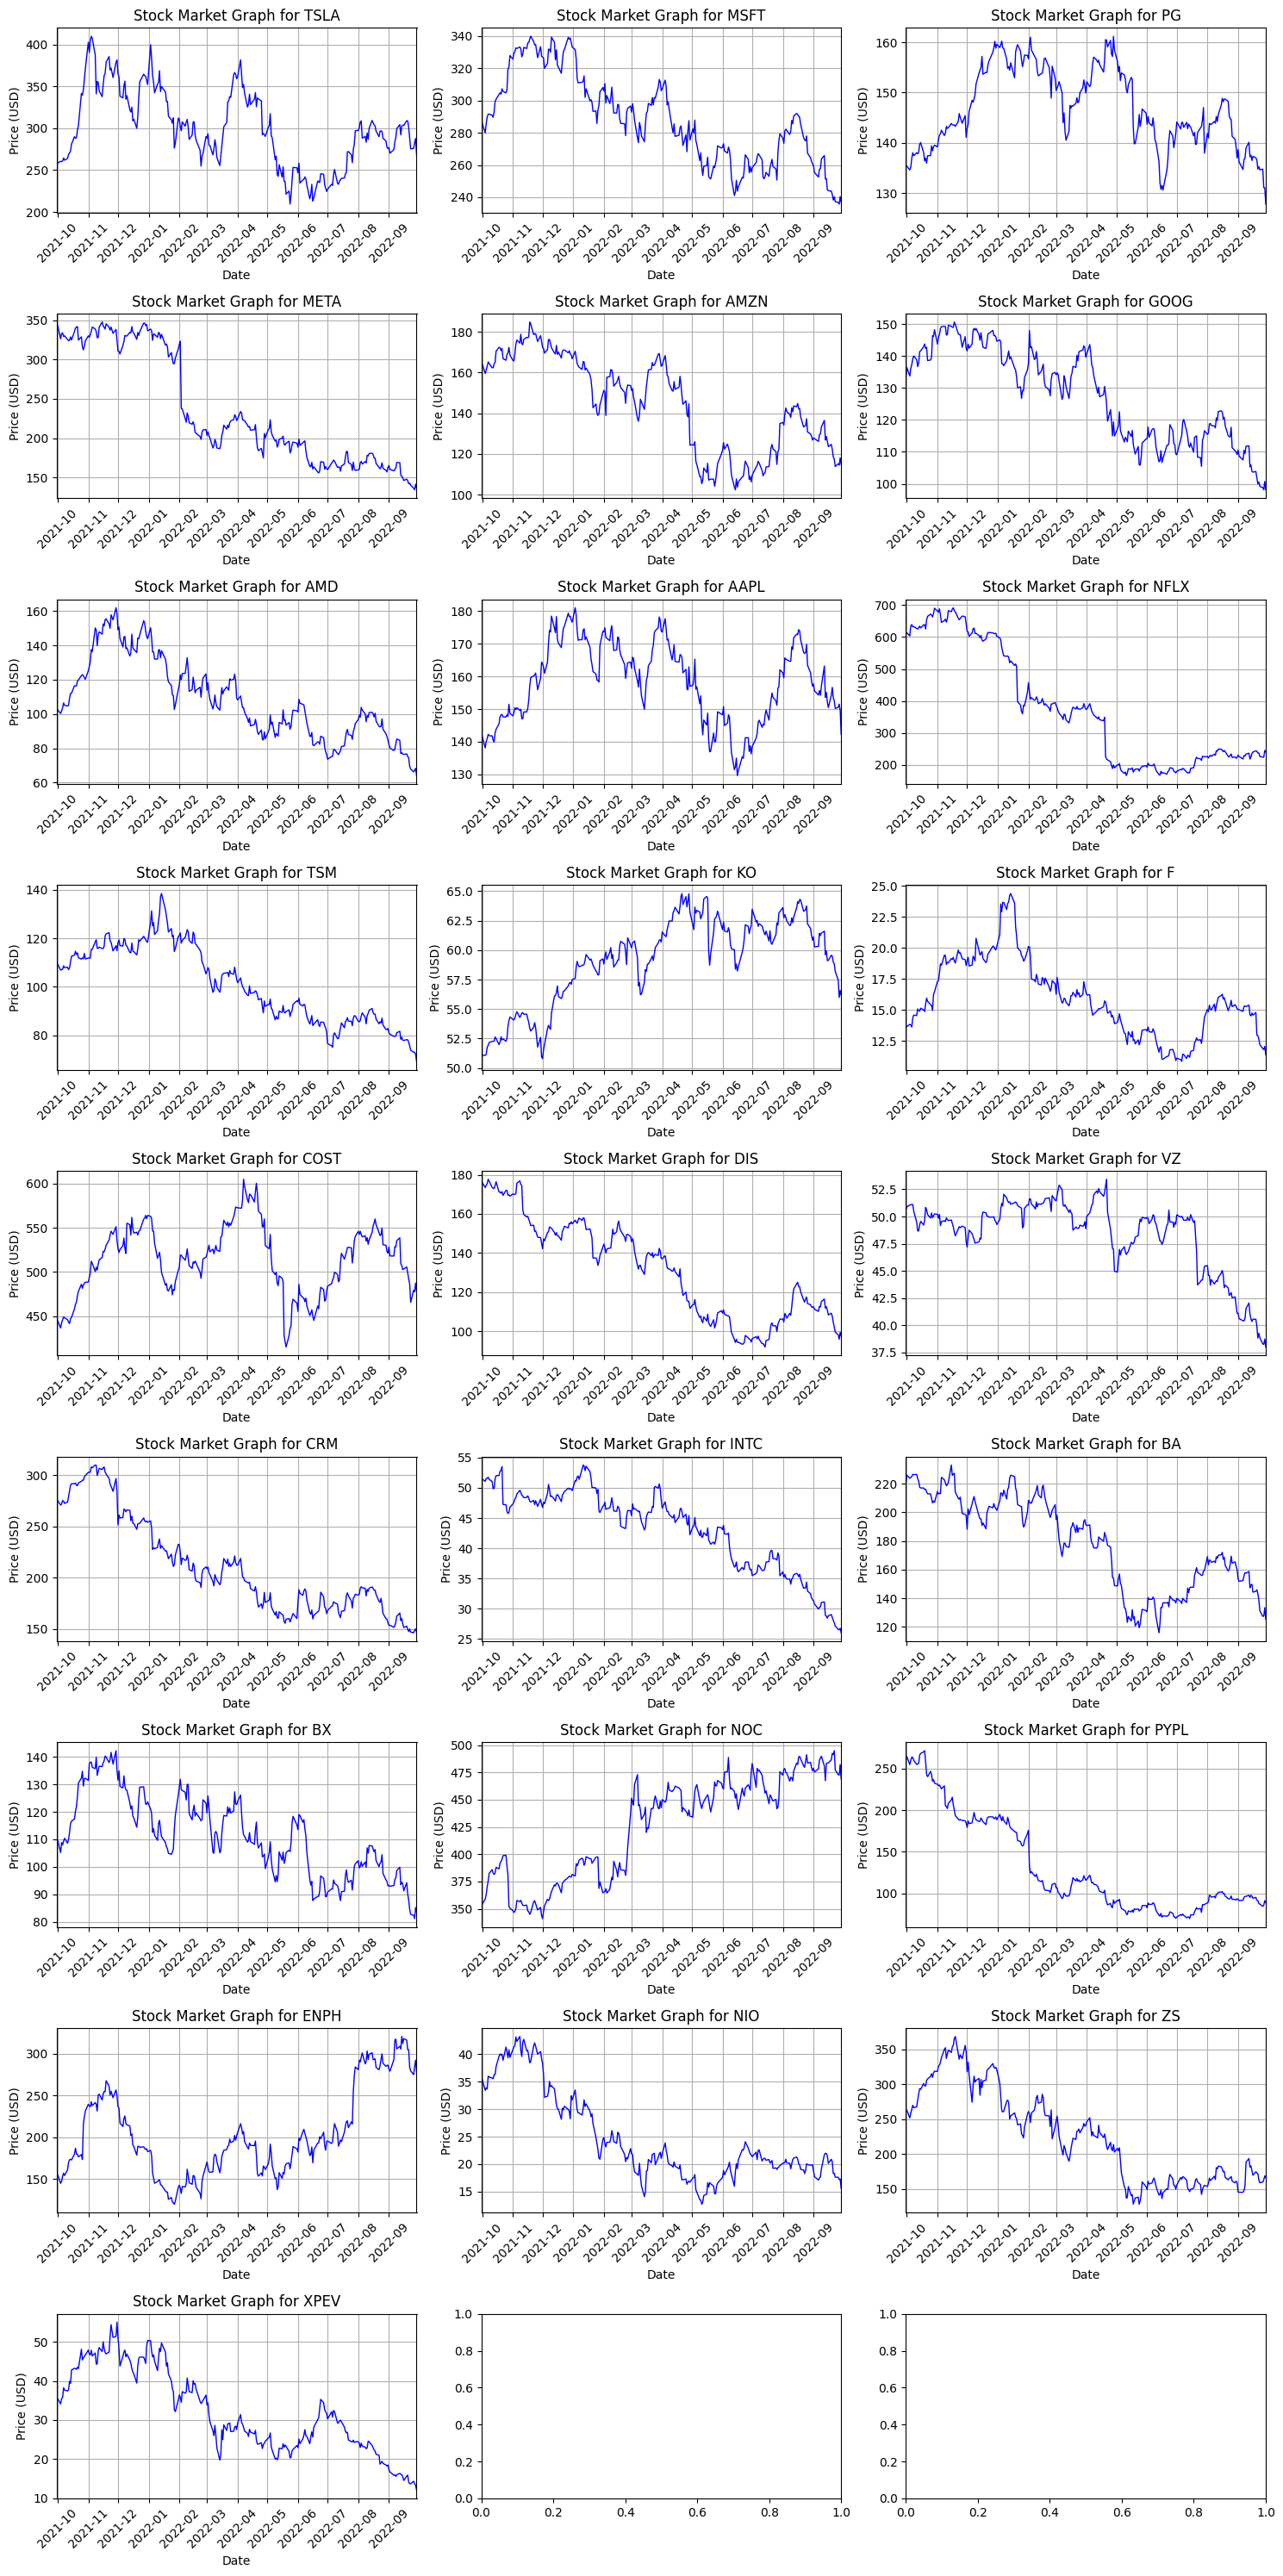

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import math

# Plotting all the stock prices over time for each market in the analysis dataset for inspection

# load data
stock_data = pd.read_csv('stock_yfinance_data.csv')
unique_stock_names = stock_data['Stock Name'].unique()

# graph layouts
num_plots = len(unique_stock_names)
num_cols = min(num_plots, 3)
num_rows = math.ceil(num_plots / num_cols)
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 30))

for i, stock_name in enumerate(unique_stock_names):
    row = i // num_cols
    col = i % num_cols

    # filter data by stock then create a copy becasue of SettingWithCopyWarning
    stock_data_filtered = stock_data[stock_data['Stock Name'] == stock_name].copy()

    # change date time format
    stock_data_filtered['Date'] = pd.to_datetime(stock_data_filtered['Date'], format='%d/%m/%Y')

    # plot graphs
    axes[row, col].plot(stock_data_filtered['Date'], stock_data_filtered['Adj Close'], color='blue', linewidth=1.0)
    axes[row, col].set_title(f'Stock Market Graph for {stock_name}')
    axes[row, col].set_xlabel('Date')
    axes[row, col].set_ylabel('Price (USD)')
    axes[row, col].grid(True)
    axes[row, col].set_xlim(stock_data_filtered['Date'].iloc[0], stock_data_filtered['Date'].iloc[-1])

    # Rotate bottom labels by 45 degrees
    for tick in axes[row, col].get_xticklabels():
        tick.set_rotation(45)

plt.tight_layout()
plt.show()


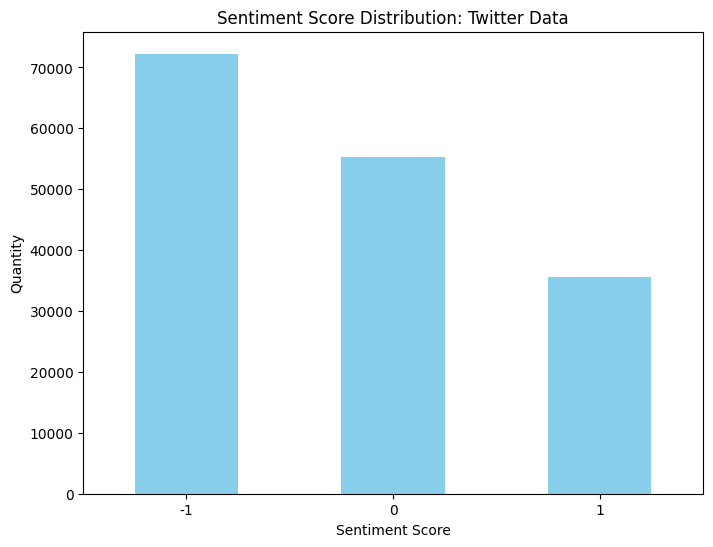

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Plotting the quantity distribution of the sentiment classes in the training datasets

# load data
df = pd.read_csv("Twitter_Data.csv") # Twitter_Data.csv | Reddit_Data.csv

# count categories
sentiment_counts = df['category'].value_counts()

# plot graph
plt.figure(figsize=(8, 6))
sentiment_counts.plot(kind='bar', color='skyblue')
plt.title('Sentiment Score Distribution: Twitter Data')
plt.xlabel('Sentiment Score')
plt.ylabel('Quantity')
plt.xticks([0, 1, 2], ['-1', '0', '1'], rotation=0)

plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Plotting the quantity distribution of tweets in relation to each stock market ticker name for analysis and control variable selection

# load data
df = pd.read_csv("stock_tweets.csv")

# count stock names
ticker_counts = df['Stock Name'].value_counts()

# plot graph
plt.figure(figsize=(10, 6))
ticker_counts.plot(kind='bar', color='skyblue')
plt.title('Ticker Name Distribution')
plt.xlabel('Ticker Name')
plt.ylabel('Frequency')

plt.show()

# SVM Model


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from tqdm import tqdm
from joblib import dump
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import warnings

warnings.filterwarnings("ignore", message="is_sparse is deprecated", category=FutureWarning) # remove some warnings

# SVM model training and visualising validation results on Twitter data

# load data
file_path = r'Twitter_Data.csv'
df = pd.read_csv(file_path)

# drop rows with missing values in clean_text and category columns
df.dropna(subset=['clean_text', 'category'], inplace=True)

# save data as seporate columns
X = df['clean_text']
y = df['category']

# split data into training and testing sets, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# using TF-IDF to vectorise the data with 100k max features
vectoriser = TfidfVectorizer(max_features=100000)
X_train_vec = vectoriser.fit_transform(X_train)
X_test_vec = vectoriser.transform(X_test)

# SGDClassifier for SVM training with hinge loss function
svm_model = SGDClassifier(loss='hinge', alpha=1e-4, max_iter=1000, tol=1e-3, n_jobs=-1, learning_rate='optimal')

n_iterations = 1000

# visualise n_interaction with tqdm loading bar
with tqdm(total=n_iterations, desc="Training", unit="iter", ncols=100) as pbar:
    for i in range(n_iterations):
        svm_model.partial_fit(X_train_vec, y_train, classes=np.unique(y_train))
        pbar.update(1)

# make predictions with test set and evaluate accuracy
y_pred = svm_model.predict(X_test_vec)
print(classification_report(y_test, y_pred))

# save the model and vectoriser
dump(svm_model, 'svm_model.joblib')
dump(vectoriser, 'tfidf_vectoriser.joblib')

# compute probabilities of each class
y_prob = svm_model.decision_function(X_test_vec)

# binarise labels
y_test_bin = label_binarize(y_test, classes=svm_model.classes_)

# plot multiclass ROC curve
plt.figure(figsize=(8, 6))
for i, class_name in enumerate(['negative', 'neutral', 'positive']):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label='ROC curve ({}) (area = {:0.2f})'.format(class_name, roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Multiclass')
plt.legend(loc="lower right")
plt.show()

# confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# display confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(svm_model.classes_))
plt.xticks(tick_marks, svm_model.classes_, rotation=45)
plt.yticks(tick_marks, svm_model.classes_)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()

# visualise values in the matrix
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > conf_matrix.max() / 2 else "black")

plt.show()


AttributeError: partially initialized module 'pandas' has no attribute 'core' (most likely due to a circular import)

Training: 100%|███████████████████████████████████████████████| 1000/1000 [05:20<00:00,  3.12iter/s]


              precision    recall  f1-score   support

        -1.0       0.91      0.62      0.74      8615
         0.0       0.79      0.98      0.87     13630
         1.0       0.90      0.87      0.88     17779

    accuracy                           0.85     40024
   macro avg       0.87      0.82      0.83     40024
weighted avg       0.86      0.85      0.85     40024



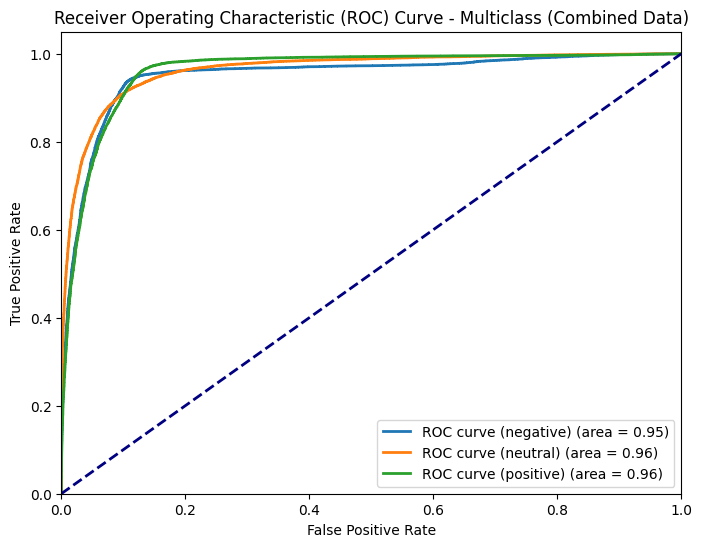

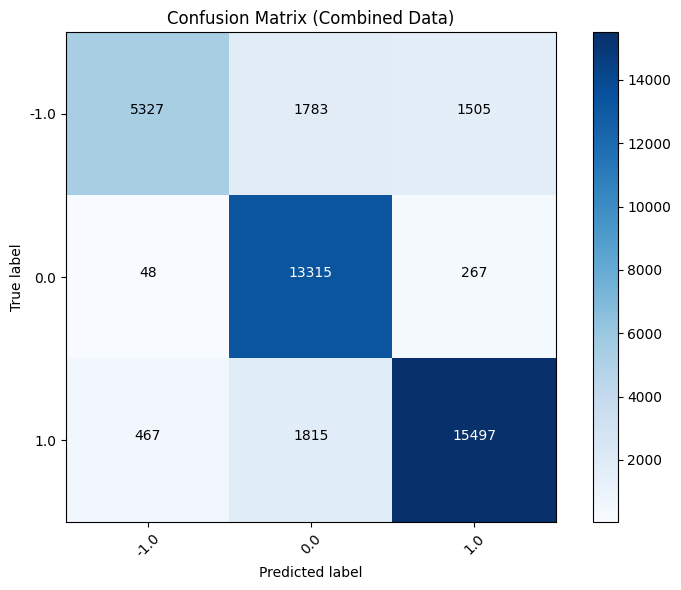

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from tqdm import tqdm
from joblib import dump
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
import warnings

warnings.filterwarnings("ignore", message="is_sparse is deprecated", category=FutureWarning) # remove warnings

# SVM model training and visualising validation results on Twitter and Reddit data
# This code is coppied from above just modified to handle two datasets for training

# load data
twitter_file_path = r'Twitter_Data.csv'
reddit_file_path = r'Reddit_Data.csv'
df_twitter = pd.read_csv(twitter_file_path)
df_reddit = pd.read_csv(reddit_file_path)

# drop rows with missing values in clean_text and category columns
df_twitter.dropna(subset=['clean_text', 'category'], inplace=True)
df_reddit.dropna(subset=['clean_text', 'category'], inplace=True)

# merge datasets into one
df_combined = pd.concat([df_twitter, df_reddit], ignore_index=True)

# save combined data as seporate columns
X_combined = df_combined['clean_text']
y_combined = df_combined['category']

# split data into training and testing sets, 20% test
X_train_combined, X_test_combined, y_train_combined, y_test_combined = train_test_split(
    X_combined, y_combined, test_size=0.2, random_state=42)

# using TF-IDF to vectorise the data with 100k max features
vectoriser = TfidfVectorizer(max_features=100000)
X_train_vec_combined = vectoriser.fit_transform(X_train_combined)
X_test_vec_combined = vectoriser.transform(X_test_combined)

# SGDClassifier for SVM training with hinge loss function
svm_model = SGDClassifier(loss='hinge', alpha=1e-4, max_iter=1000, tol=1e-3, n_jobs=-1, learning_rate='optimal')

n_iterations = 1000

# visualise n_interaction with tqdm loading bar
with tqdm(total=n_iterations, desc="Training", unit="iter", ncols=100) as pbar:
    for i in range(n_iterations):
        svm_model.partial_fit(X_train_vec_combined, y_train_combined, classes=np.unique(y_train_combined))
        pbar.update(1)

# make predictions with test set and evaluate accuracy
y_pred_combined = svm_model.predict(X_test_vec_combined)
print(classification_report(y_test_combined, y_pred_combined))

# save the model and vectoriser
dump(svm_model, 'svm_model.joblib')
dump(vectoriser, 'tfidf_vectoriser.joblib')

# compute probabilities of each class
y_prob_combined = svm_model.decision_function(X_test_vec_combined)

# binarise labels
y_test_bin_combined = label_binarize(y_test_combined, classes=svm_model.classes_)

# plot multiclass ROC curve
plt.figure(figsize=(8, 6))
for i, class_name in enumerate(['negative', 'neutral', 'positive']):
    fpr, tpr, _ = roc_curve(y_test_bin_combined[:, i], y_prob_combined[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label='ROC curve ({}) (area = {:0.2f})'.format(class_name, roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Multiclass (Combined Data)')
plt.legend(loc="lower right")
plt.show()

# confusion matrix
conf_matrix_combined = confusion_matrix(y_test_combined, y_pred_combined)

# display confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix_combined, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix (Combined Data)')
plt.colorbar()
tick_marks_combined = np.arange(len(svm_model.classes_))
plt.xticks(tick_marks_combined, svm_model.classes_, rotation=45)
plt.yticks(tick_marks_combined, svm_model.classes_)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()

# visualise values in the matrix
for i in range(conf_matrix_combined.shape[0]):
    for j in range(conf_matrix_combined.shape[1]):
        plt.text(j, i, format(conf_matrix_combined[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix_combined[i, j] > conf_matrix_combined.max() / 2 else "black")

plt.show()


# LSTM Model

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Embedding, Dense, SpatialDropout1D, Bidirectional, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from joblib import dump
from tqdm import tqdm

# LSTM model training and visualising validation results on Twitter

# load data
file_path = r'Twitter_Data.csv'
df = pd.read_csv(file_path)

# drop rows with missing values in clean_text and category columns
df.dropna(subset=['clean_text', 'category'], inplace=True)

# save data as seporate columns
X = df['clean_text']
y = df['category']

# target label encoding
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# split data into training and testing sets, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# tokenise text data
max_words = 10000
tokeniser = Tokenizer(num_words=max_words)
tokeniser.fit_on_texts(X_train)
X_train_seq = tokeniser.texts_to_sequences(X_train)
X_test_seq = tokeniser.texts_to_sequences(X_test)

# sequence padding for equal input sizes
max_len = 100
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post')

# LSTM model with dense layer for greater depth
embedding_dim = 128
lstm_units = 64
model = Sequential([
    Embedding(max_words, embedding_dim, input_length=max_len),
    SpatialDropout1D(0.2),
    Bidirectional(LSTM(lstm_units, dropout=0.2, recurrent_dropout=0.2)),
    Dense(64, activation='relu'), # relu activation fucntion
    Dropout(0.5),
    Dense(3, activation='softmax')
])

# compile model
model.compile(loss='sparse_categorical_crossentropy', optimiser='adam', metrics=['accuracy'])
callbacks = [
    EarlyStopping(patience=3, monitor='val_loss'),
    ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)
]

# train the LSTM model
batch_size = 1024
epochs = 6
history = model.fit(X_train_pad, y_train, validation_split=0.2, batch_size=batch_size, epochs=epochs, callbacks=callbacks)

# get best model
model.load_weights('best_model.h5')

# compute predictions against test set and decode them
y_pred_proba = model.predict(X_test_pad)
y_pred_labels = label_encoder.inverse_transform(np.argmax(y_pred_proba, axis=1))
y_true_labels = label_encoder.inverse_transform(y_test)

print(classification_report(y_true_labels, y_pred_labels))

# confusion matrix
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)

# plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# plot multiclass ROC curve
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(label_encoder.classes_)):
    fpr[i], tpr[i], _ = roc_curve((y_test == i), y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
plt.figure()
for i in range(len(label_encoder.classes_)):
    plt.plot(fpr[i], tpr[i], label='ROC curve (class {}) (area = {:.2f})'.format(label_encoder.inverse_transform([i])[0], roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve')
plt.legend(loc="lower right")
plt.show()

# plot learning accuracy Curve
plt.figure()
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Learning Curve')
plt.legend()
plt.grid(True)
plt.show()

# plot training and validation loss
plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# save tokeniser
dump(tokeniser, 'tokeniser.joblib')


Epoch 1/6
 29/100 [=======>......................] - ETA: 30s - loss: 1.0177 - accuracy: 0.4970

KeyboardInterrupt: 

Epoch 1/6
126/126 [==============================] - 569s 4s/step - loss: 0.7199 - accuracy: 0.6844 - val_loss: 0.2872 - val_accuracy: 0.9046
Epoch 2/6


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


126/126 [==============================] - 531s 4s/step - loss: 0.2291 - accuracy: 0.9306 - val_loss: 0.1769 - val_accuracy: 0.9466
Epoch 3/6
126/126 [==============================] - 535s 4s/step - loss: 0.1658 - accuracy: 0.9534 - val_loss: 0.1646 - val_accuracy: 0.9513
Epoch 4/6
126/126 [==============================] - 505s 4s/step - loss: 0.1418 - accuracy: 0.9607 - val_loss: 0.1535 - val_accuracy: 0.9543
Epoch 5/6
126/126 [==============================] - 507s 4s/step - loss: 0.1276 - accuracy: 0.9646 - val_loss: 0.1494 - val_accuracy: 0.9577
Epoch 6/6
1251/1251 [==============================] - 59s 47ms/step
              precision    recall  f1-score   support

        -1.0       0.91      0.93      0.92      8615
         0.0       0.98      0.98      0.98     13630
         1.0       0.97      0.96      0.96     17779

    accuracy                           0.96     40024
   macro avg       0.95      0.96      0.95     40024
weighted avg       0.96      0.96      0.96    

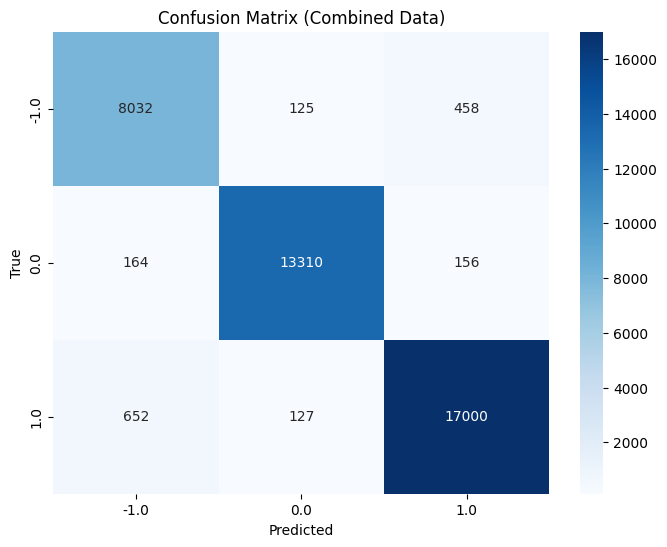

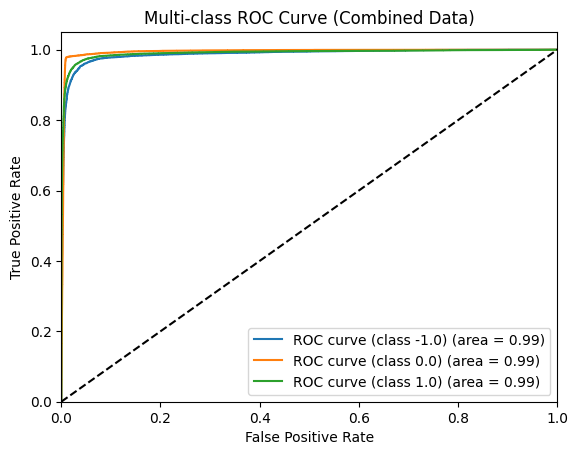

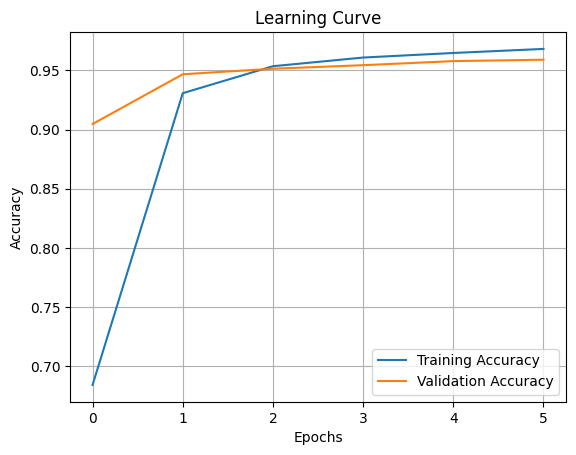

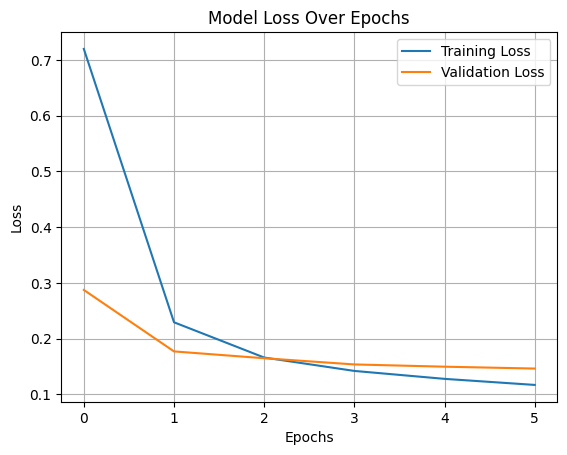

['tokenizer_combined.joblib']

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Embedding, Dense, SpatialDropout1D, Bidirectional, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from joblib import dump
from tqdm import tqdm

# LSTM model training and visualising validation results on Twitter and Reddit data
# This code is coppied from above just modified to handle two datasets for training

# load data
twitter_file_path = r'Twitter_Data.csv'
reddit_file_path = r'Reddit_Data.csv'
df_twitter = pd.read_csv(twitter_file_path)
df_reddit = pd.read_csv(reddit_file_path)

# drop rows with missing values in clean_text and category columns
df_twitter.dropna(subset=['clean_text', 'category'], inplace=True)
df_reddit.dropna(subset=['clean_text', 'category'], inplace=True)

# merge datasets into one
df_combined = pd.concat([df_twitter, df_reddit], ignore_index=True)

# save data as seporate columns
X_combined = df_combined['clean_text']
y_combined = df_combined['category']

# target label encoding
label_encoder = LabelEncoder()
y_combined = label_encoder.fit_transform(y_combined)

# split data into training and testing sets, 20% test
X_train_combined, X_test_combined, y_train_combined, y_test_combined = train_test_split(X_combined, y_combined, test_size=0.2, random_state=42)

# tokenise text data
max_words = 10000
tokeniser = Tokenizer(num_words=max_words)
tokeniser.fit_on_texts(X_train_combined)
X_train_seq_combined = tokeniser.texts_to_sequences(X_train_combined)
X_test_seq_combined = tokeniser.texts_to_sequences(X_test_combined)

# sequence padding for equal input sizes
max_len = 100
X_train_pad_combined = pad_sequences(X_train_seq_combined, maxlen=max_len, padding='post')
X_test_pad_combined = pad_sequences(X_test_seq_combined, maxlen=max_len, padding='post')

# LSTM model with dense layer for greater depth
embedding_dim = 128
lstm_units = 64
model = Sequential([
    Embedding(max_words, embedding_dim, input_length=max_len),
    SpatialDropout1D(0.2),
    Bidirectional(LSTM(lstm_units, dropout=0.2, recurrent_dropout=0.2)),
    Dense(64, activation='relu'), # relu activation function
    Dropout(0.5),
    Dense(3, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', optimiser='adam', metrics=['accuracy'])

callbacks = [
    EarlyStopping(patience=3, monitor='val_loss'),
    ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)
]

# train the LSTM model
batch_size = 1024
epochs = 6

history = model.fit(X_train_pad_combined, y_train_combined, validation_split=0.2, batch_size=batch_size, epochs=epochs, callbacks=callbacks)

# get best model
model.load_weights('best_model.h5')

# compute predictions against test set and decode them
y_pred_proba_combined = model.predict(X_test_pad_combined)
y_pred_labels_combined = label_encoder.inverse_transform(np.argmax(y_pred_proba_combined, axis=1))
y_true_labels_combined = label_encoder.inverse_transform(y_test_combined)

print(classification_report(y_true_labels_combined, y_pred_labels_combined))

# confusion matrix
conf_matrix_combined = confusion_matrix(y_true_labels_combined, y_pred_labels_combined)

# plotting Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_combined, annot=True, cmap='Blues', fmt='g', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix (Combined Data)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# plot multiclass ROC curve
fpr_combined = dict()
tpr_combined = dict()
roc_auc_combined = dict()
for i in range(len(label_encoder.classes_)):
    fpr_combined[i], tpr_combined[i], _ = roc_curve((y_test_combined == i), y_pred_proba_combined[:, i])
    roc_auc_combined[i] = auc(fpr_combined[i], tpr_combined[i])
plt.figure()
for i in range(len(label_encoder.classes_)):
    plt.plot(fpr_combined[i], tpr_combined[i], label='ROC curve (class {}) (area = {:.2f})'.format(label_encoder.inverse_transform([i])[0], roc_auc_combined[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve (Combined Data)')
plt.legend(loc="lower right")
plt.show()

# plot learning accuracy Curve
plt.figure()
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Learning Curve')
plt.legend()
plt.grid(True)
plt.show()

# plot training and validation loss
plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Save tokeniser
dump(tokeniser, 'tokeniser.joblib')


# BERT Model

Using device: cuda


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/4: Avg Train Loss: 0.3010070274096856, Accuracy: 0.9654537644965331


Epoch 2/4: Avg Train Loss: 0.08776988081224592, Accuracy: 0.9776646008467816


Epoch 3/4: Avg Train Loss: 0.057267986601072345, Accuracy: 0.9814076210345463


Epoch 4/4: Avg Train Loss: 0.042169480272902356, Accuracy: 0.9824200773148433


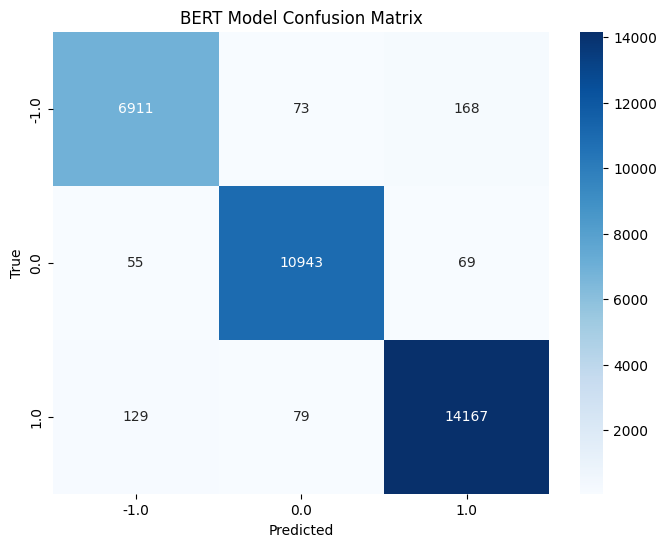

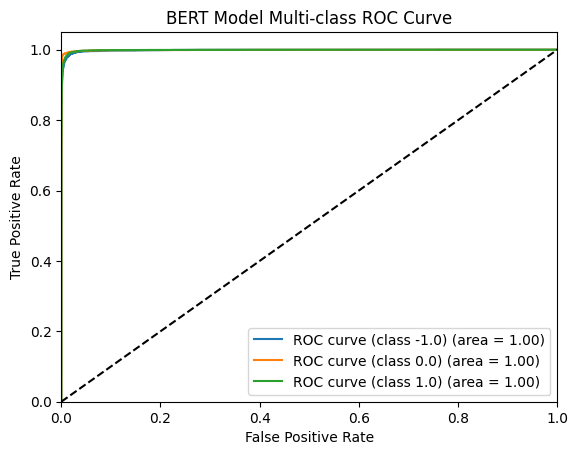

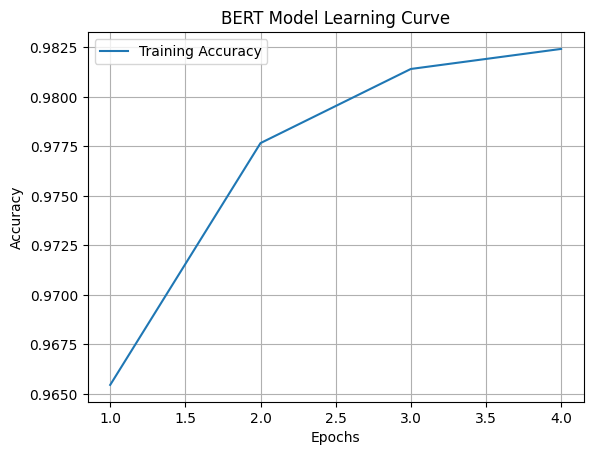

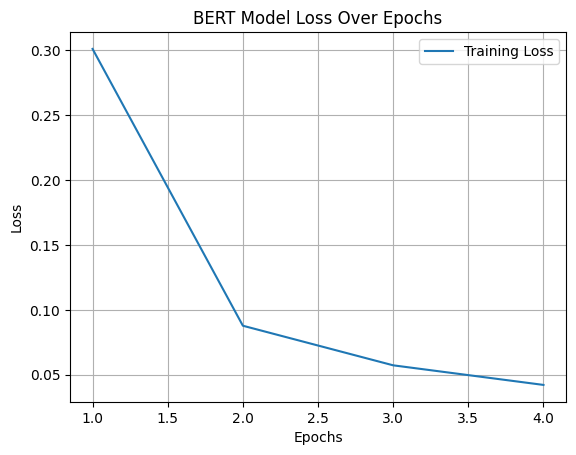

In [ ]:
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler
from tqdm import tqdm

# BERT model training and visualising validation results on Twitter

# use cuda to see if gpu is available, else use cpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

# Load the data
file_path = 'Twitter_Data.csv'
df = pd.read_csv(file_path)

# drop rows with missing values in clean_text and category columns
df.dropna(subset=['clean_text', 'category'], inplace=True)

# save data as seporate columns
X = df['clean_text']
y = df['category']

# target labels encoding
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
num_classes = len(label_encoder.classes_)

# split data into training and testing sets, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# get pre-trained bert-base-uncased tokeniser and tokenise text data
tokeniser = BertTokenizer.from_pretrained('bert-base-uncased')
X_train_encodings = tokeniser(X_train.tolist(), truncation=True, padding=True)
X_test_encodings = tokeniser(X_test.tolist(), truncation=True, padding=True)

# PyTorch tensors conversions
X_train_input_ids = torch.tensor(X_train_encodings['input_ids']).to(device)
X_train_attention_mask = torch.tensor(X_train_encodings['attention_mask']).to(device)
y_train_tensor = torch.tensor(y_train).to(device)
X_test_input_ids = torch.tensor(X_test_encodings['input_ids']).to(device)
X_test_attention_mask = torch.tensor(X_test_encodings['attention_mask']).to(device)
y_test_tensor = torch.tensor(y_test).to(device)

# batch size
batch_size = 128

# DataLoaders for training and testing datasets
train_dataset = TensorDataset(X_train_input_ids, X_train_attention_mask, y_train_tensor)
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batch_size)
test_dataset = TensorDataset(X_test_input_ids, X_test_attention_mask, y_test_tensor)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=batch_size)

# start BERT model with sequence classification with adam optimiser and loss function
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_classes)
model = model.to(device)
optimiser = AdamW(model.parameters(), lr=2e-5)
loss_fn = torch.nn.CrossEntropyLoss()

# training parameters
num_epochs = 4
best_accuracy = 0.0
accuracy_per_epoch = []
loss_per_epoch = []

# training the model
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch in tqdm(train_dataloader, desc=f'Epoch {epoch + 1}/{num_epochs}', leave=False):
        input_ids, attention_mask, labels = batch
        optimiser.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimiser.step()
    avg_train_loss = total_loss / len(train_dataloader)
    loss_per_epoch.append(avg_train_loss)

    # evaluation
    model.eval()
    y_true = []
    y_pred = []
    y_pred_proba = []  # <- reset for each epoch
    for batch in test_dataloader:
        input_ids, attention_mask, labels = batch
        with torch.no_grad():
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            _, predicted = torch.max(logits, 1)
            y_true.extend(labels.tolist())
            y_pred.extend(predicted.tolist())
            softmax_output = torch.nn.functional.softmax(logits, dim=1)
            y_pred_proba.extend(softmax_output.tolist())
    accuracy = accuracy_score(y_true, y_pred)
    accuracy_per_epoch.append(accuracy)
    print(f"Epoch {epoch+1}/{num_epochs}: Avg Train Loss: {avg_train_loss}, Accuracy: {accuracy}")

    # save best model
    if accuracy > best_accuracy:
        torch.save(model.state_dict(), 'best_bert_model.pth')
        best_accuracy = accuracy

# confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('BERT Model Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# multi-class ROC curve
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(label_encoder.classes_)):
    fpr[i], tpr[i], _ = roc_curve((y_test == i), np.array(y_pred_proba)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
for i in range(len(label_encoder.classes_)):
    plt.plot(fpr[i], tpr[i], label='ROC curve (class {}) (area = {:.2f})'.format(label_encoder.inverse_transform([i])[0], roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('BERT Model Multi-class ROC Curve')
plt.legend(loc="lower right")
plt.show()

# learning accuracy curve
plt.figure()
plt.plot(range(1, num_epochs + 1), accuracy_per_epoch, label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('BERT Model Learning Curve')
plt.legend()
plt.grid(True)
plt.show()

# training and validation loss curve
plt.figure()
plt.plot(range(1, num_epochs + 1), loss_per_epoch, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('BERT Model Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

Using device: cuda


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch

Epoch 1/4: Avg Train Loss: 0.2633014167655262, Accuracy: 0.9681191285228863


Epoch 2/4: Avg Train Loss: 0.08261285401094588, Accuracy: 0.9775884469318409


Epoch 3/4: Avg Train Loss: 0.05644367609491689, Accuracy: 0.9806366180291824


Epoch 4/4: Avg Train Loss: 0.04113137699393027, Accuracy: 0.979787127723366


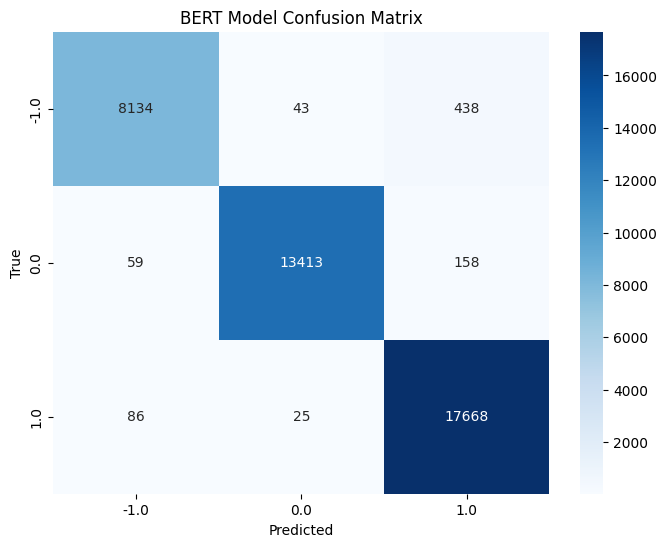

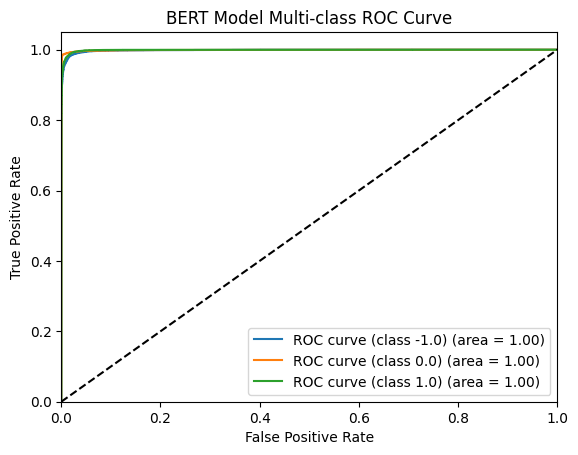

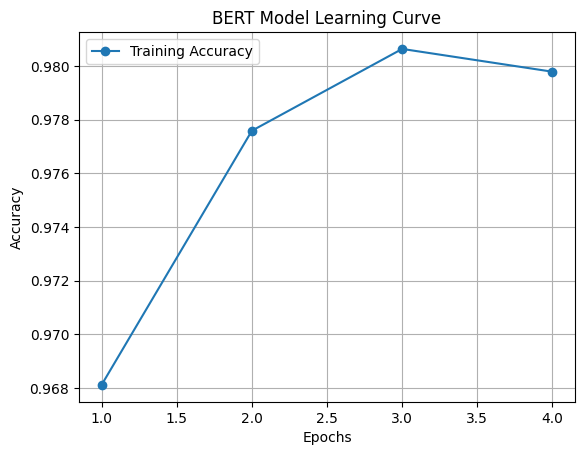

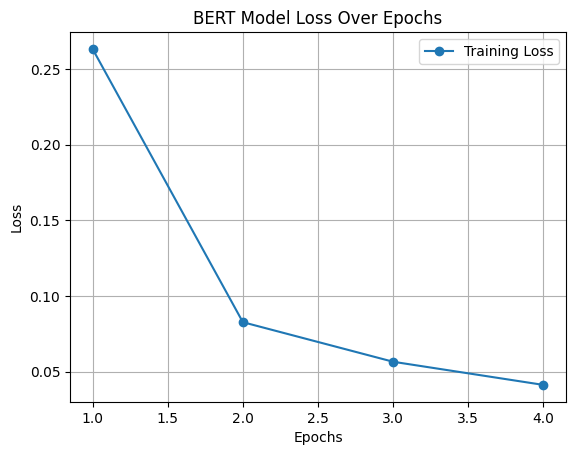

In [ ]:
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler
from tqdm import tqdm

# BERT model training and visualising validation results on Twitter and Reddit data
# This code is coppied from above just modified to handle two datasets for training

# use cuda to see if gpu is available, else use cpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

# Load the data
twitter_file_path = 'Twitter_Data.csv'
reddit_file_path = 'Reddit_Data.csv'
twitter_df = pd.read_csv(twitter_file_path)
reddit_df = pd.read_csv(reddit_file_path)

# drop rows with missing values in clean_text and category columns
twitter_df.dropna(subset=['clean_text', 'category'], inplace=True)
reddit_df.dropna(subset=['clean_text', 'category'], inplace=True)

# merge the two datasets
combined_df = pd.concat([twitter_df, reddit_df], ignore_index=True)

# save data as seporate columns
X = combined_df['clean_text']
y = combined_df['category']

# target labels encoding
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
num_classes = len(label_encoder.classes_)

# split data into training and testing sets, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# get pre-trained bert-base-uncased tokeniser and tokenise text data
tokeniser = BertTokenizer.from_pretrained('bert-base-uncased')
max_length = 128 # length limit due to vram issues
X_train_encodings = tokeniser(X_train.tolist(), truncation=True, padding=True, max_length=max_length)
X_test_encodings = tokeniser(X_test.tolist(), truncation=True, padding=True, max_length=max_length)

# PyTorch tensors conversions
X_train_input_ids = torch.tensor(X_train_encodings['input_ids']).to(device)
X_train_attention_mask = torch.tensor(X_train_encodings['attention_mask']).to(device)
y_train_tensor = torch.tensor(y_train).to(device)
X_test_input_ids = torch.tensor(X_test_encodings['input_ids']).to(device)
X_test_attention_mask = torch.tensor(X_test_encodings['attention_mask']).to(device)
y_test_tensor = torch.tensor(y_test).to(device)

# batch size
batch_size = 128

# DataLoaders for training and testing datasets
train_dataset = TensorDataset(X_train_input_ids, X_train_attention_mask, y_train_tensor)
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batch_size)
test_dataset = TensorDataset(X_test_input_ids, X_test_attention_mask, y_test_tensor)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=batch_size)

# start BERT model for sequence classification with adam optimiser and loss function
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_classes)
model = model.to(device)
optimiser = AdamW(model.parameters(), lr=2e-5)
loss_fn = torch.nn.CrossEntropyLoss()

# training parameters
num_epochs = 4
best_accuracy = 0.0
accuracy_per_epoch = []
loss_per_epoch = []

# training the model
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch in tqdm(train_dataloader, desc=f'Epoch {epoch + 1}/{num_epochs}', leave=False):
        input_ids, attention_mask, labels = batch
        optimiser.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimiser.step()
    avg_train_loss = total_loss / len(train_dataloader)
    loss_per_epoch.append(avg_train_loss)

    # evaluation
    model.eval()
    y_true = []
    y_pred = []
    y_pred_proba = []  # <- reset for each epoch
    for batch in test_dataloader:
        input_ids, attention_mask, labels = batch
        with torch.no_grad():
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            _, predicted = torch.max(logits, 1)
            y_true.extend(labels.tolist())
            y_pred.extend(predicted.tolist())
            softmax_output = torch.nn.functional.softmax(logits, dim=1)
            y_pred_proba.extend(softmax_output.tolist())
    accuracy = accuracy_score(y_true, y_pred)
    accuracy_per_epoch.append(accuracy)
    print(f"Epoch {epoch+1}/{num_epochs}: Avg Train Loss: {avg_train_loss}, Accuracy: {accuracy}")

    # save best model
    if accuracy > best_accuracy:
        torch.save(model.state_dict(), 'best_bert_model.pth')
        best_accuracy = accuracy

# confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('BERT Model Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# multi-class ROC curve
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(label_encoder.classes_)):
    fpr[i], tpr[i], _ = roc_curve((y_test == i), np.array(y_pred_proba)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
for i in range(len(label_encoder.classes_)):
    plt.plot(fpr[i], tpr[i], label='ROC curve (class {}) (area = {:.2f})'.format(label_encoder.inverse_transform([i])[0], roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('BERT Model Multi-class ROC Curve')
plt.legend(loc="lower right")
plt.show()

# learning accuracy Curve
plt.figure()
plt.plot(range(1, num_epochs + 1), accuracy_per_epoch, label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('BERT Model Learning Curve')
plt.legend()
plt.grid(True)
plt.show()

# training and validation loss curve
plt.figure()
plt.plot(range(1, num_epochs + 1), loss_per_epoch, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('BERT Model Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()


# Predicted Sentiment scores


Possible Stock Ticker Names: TSLA MSFT PG META AMZN GOOG AMD AAPL NFLX TSM KO F COST DIS VZ CRM INTC BA BX NOC PYPL ENPH NIO ZS XPEV

Enter the name of the stock ticker you'd like to analyze: PG


Processing Tweets: 100%|███████████████████████████████████████| 4089/4089 [00:25<00:00, 159.81it/s]
<ipython-input-3-bdfb8a382f6a>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  desired_stock_tweets['Sentiment'] = sentiments
<ipython-input-3-bdfb8a382f6a>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  desired_stock_tweets['Date'] = pd.to_datetime(desired_stock_tweets['Date'], format='%Y-%m-%d %H:%M:%S%z')


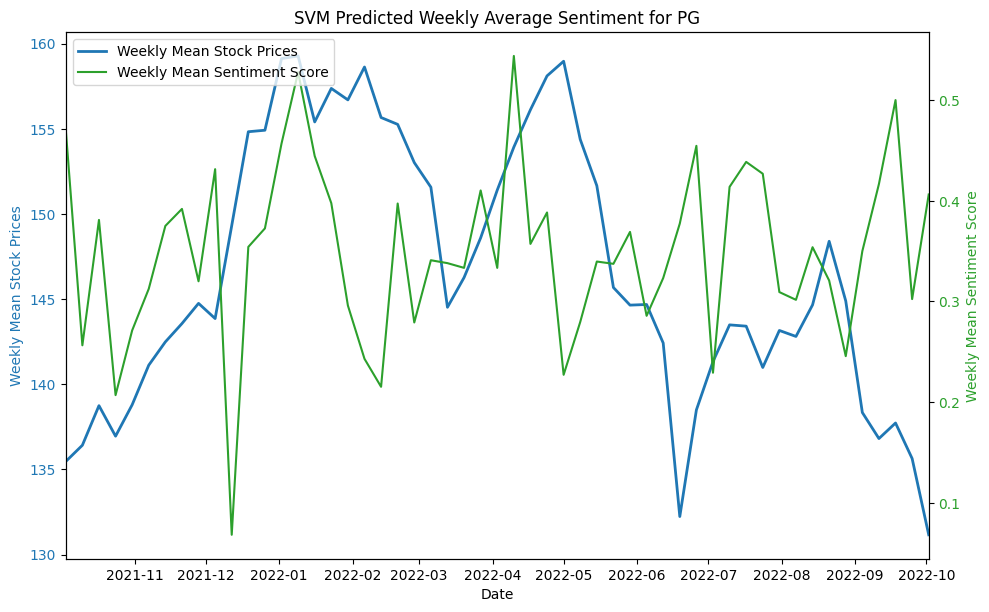

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from joblib import load
from tqdm import tqdm
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
import numpy as np

# Use SVM model to predict sentiment scores for each tweet and calculate the mean for each weak and plot alongside with true stock prices for selected stock market

# load data
stock_data = pd.read_csv('stock_yfinance_data.csv')
tweets_df = pd.read_csv('stock_tweets.csv')
svm_model = load('svm_model.joblib')
vectoriser = load('tfidf_vectoriser.joblib')

# graphing the weakly mean stock prices and weekly mean sentiment score over time
def plot_stock_and_weekly_sentiment(stock_name):

    # filter for user selected stock name
    stock_data_filtered = stock_data[stock_data['Stock Name'] == stock_name].copy()
    stock_data_filtered['Date'] = pd.to_datetime(stock_data_filtered['Date'], format='%d/%m/%Y')
    stock_data_filtered.set_index('Date', inplace=True)
    desired_stock_tweets = tweets_df[tweets_df['Stock Name'] == stock_name]

    # call SVM model for sentiment analysis with tqdm loading bar
    sentiments = []
    with tqdm(total=len(desired_stock_tweets), desc="Processing Tweets", ncols=100) as pbar:
        for index, row in desired_stock_tweets.iterrows():
            tweet_vec = vectoriser.transform([row['Tweet']])
            sentiment = svm_model.predict(tweet_vec)[0]
            sentiments.append(sentiment)
            pbar.update(1)
    desired_stock_tweets['Sentiment'] = sentiments

    # convert datetime format
    desired_stock_tweets['Date'] = pd.to_datetime(desired_stock_tweets['Date'], format='%Y-%m-%d %H:%M:%S%z')
    desired_stock_tweets.set_index('Date', inplace=True)

    # group tweets and stock data by each week and calculate mean sentiment for each week
    mean_sentiments_per_week = desired_stock_tweets.groupby(pd.Grouper(freq='W')).agg({'Sentiment': 'mean'})
    mean_stock_prices_per_week = stock_data_filtered['Adj Close'].resample('W').mean()

    # graphing
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # blue: stock prices
    color = 'tab:blue'
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Weekly Mean Stock Prices', color=color)
    ax1.plot(mean_stock_prices_per_week.index, mean_stock_prices_per_week.values, color=color, linewidth=2.0, label='Weekly Mean Stock Prices')
    ax1.tick_params(axis='y', labelcolor=color)

    # green: sentiment scores
    ax2 = ax1.twinx()
    color = 'tab:green'
    ax2.set_ylabel('Weekly Mean Sentiment Score', color=color)
    ax2.plot(mean_sentiments_per_week.index, mean_sentiments_per_week['Sentiment'], color=color, label='Weekly Mean Sentiment Score')
    ax2.tick_params(axis='y', labelcolor=color)

    # x axis limits for the graph as it was giving gaps
    ax1.set_xlim(mean_stock_prices_per_week.index[0], mean_stock_prices_per_week.index[-1])

    # legend
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='upper left')

    fig.tight_layout()
    plt.title(f'SVM Predicted Weekly Average Sentiment for {stock_name}')
    plt.show()

def main():
    unique_stock_names = stock_data['Stock Name'].unique()
    print("Ticker Names:", ' '.join(unique_stock_names))
    desired_stock_ticker = input("\nEnter a stock ticker you would like to analyse: ")
    if desired_stock_ticker not in unique_stock_names:
        print("Invalid stock ticker name.")
        return
    plot_stock_and_weekly_sentiment(desired_stock_ticker)

if __name__ == "__main__":
    main()


Possible Stock Ticker Names: TSLA MSFT PG META AMZN GOOG AMD AAPL NFLX TSM KO F COST DIS VZ CRM INTC BA BX NOC PYPL ENPH NIO ZS XPEV

Enter the name of the stock ticker you'd like to analyze: PG
128/128 [==============================] - 6s 41ms/step


<ipython-input-4-f33934d007b2>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  desired_stock_tweets['Sentiment'] = np.argmax(sentiments, axis=1) - 1
<ipython-input-4-f33934d007b2>:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  desired_stock_tweets['Date'] = pd.to_datetime(desired_stock_tweets['Date'], format='%Y-%m-%d %H:%M:%S%z')


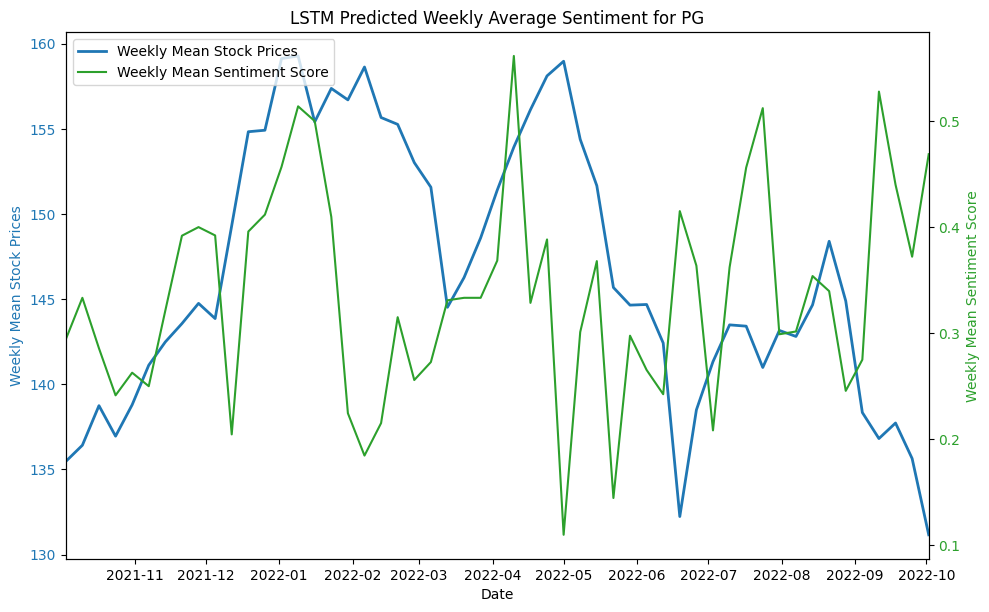

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from joblib import load
from tqdm import tqdm
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
import numpy as np

# Use LSTM model to predict sentiment scores for each tweet and calculate the mean for each weak and plot alongside with true stock prices for selected stock market

# load data
stock_data = pd.read_csv('stock_yfinance_data.csv')
tweets_df = pd.read_csv('stock_tweets.csv')
model = load_model('best_model.h5')
tokeniser = load('tokeniser.joblib')

# graphing the weakly mean stock prices and weekly mean sentiment score over time
def plot_stock_and_weekly_sentiment(stock_name):

    # filter for user selected stock name
    stock_data_filtered = stock_data[stock_data['Stock Name'] == stock_name].copy()
    stock_data_filtered['Date'] = pd.to_datetime(stock_data_filtered['Date'], format='%d/%m/%Y')
    stock_data_filtered.set_index('Date', inplace=True)
    desired_stock_tweets = tweets_df[tweets_df['Stock Name'] == stock_name]

    # tokenise and pad sequences for the tweets
    sequences = tokeniser.texts_to_sequences(desired_stock_tweets['Tweet'])
    max_len = 100
    X_pad = pad_sequences(sequences, maxlen=max_len, padding='post')

    # call LSTM model for sentiment analysis (removed tqdm loading bar due to error prints)
    sentiments = model.predict(X_pad)
    sentiments = np.clip(sentiments, -1, 1)

    # add sentiment scores to the tweets dataframe
    desired_stock_tweets['Sentiment'] = np.argmax(sentiments, axis=1) - 1

    # convert datetime format
    desired_stock_tweets['Date'] = pd.to_datetime(desired_stock_tweets['Date'], format='%Y-%m-%d %H:%M:%S%z')
    desired_stock_tweets.set_index('Date', inplace=True)

    # group tweets and stock data by each week and calculate mean sentiment for each week
    mean_sentiments_per_week = desired_stock_tweets.groupby(pd.Grouper(freq='W')).agg({'Sentiment': 'mean'})
    mean_stock_prices_per_week = stock_data_filtered['Adj Close'].resample('W').mean()

    # graphing
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # blue: stock prices
    color = 'tab:blue'
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Weekly Mean Stock Prices', color=color)
    ax1.plot(mean_stock_prices_per_week.index, mean_stock_prices_per_week.values, color=color, linewidth=2.0, label='Weekly Mean Stock Prices')
    ax1.tick_params(axis='y', labelcolor=color)

    # green: sentiment scores
    ax2 = ax1.twinx()
    color = 'tab:green'
    ax2.set_ylabel('Weekly Mean Sentiment Score', color=color)
    ax2.plot(mean_sentiments_per_week.index, mean_sentiments_per_week['Sentiment'], color=color, label='Weekly Mean Sentiment Score')
    ax2.tick_params(axis='y', labelcolor=color)

    # x axis limits for the graph as it was giving gaps
    ax1.set_xlim(mean_stock_prices_per_week.index[0], mean_stock_prices_per_week.index[-1])

    # legend
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='upper left')

    fig.tight_layout()
    plt.title(f'LSTM Predicted Weekly Average Sentiment for {stock_name}')
    plt.show()

def main():
    unique_stock_names = stock_data['Stock Name'].unique()
    print("Ticker Names:", ' '.join(unique_stock_names))
    desired_stock_ticker = input("\nEnter a stock ticker you would like to analyse: ")
    if desired_stock_ticker not in unique_stock_names:
        print("Invalid stock ticker name.")
        return
    plot_stock_and_weekly_sentiment(desired_stock_ticker)

if __name__ == "__main__":
    main()


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Possible Stock Ticker Names: TSLA MSFT PG META AMZN GOOG AMD AAPL NFLX TSM KO F COST DIS VZ CRM INTC BA BX NOC PYPL ENPH NIO ZS XPEV


100%|██████████| 8/8 [30:40<00:00, 230.08s/it]
<ipython-input-11-ceebc8577d22>:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  desired_stock_tweets['Sentiment_Prob'] = sentiment_probs
<ipython-input-11-ceebc8577d22>:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  desired_stock_tweets['Sentiment_Prob'] = (desired_stock_tweets['Sentiment_Prob'] - min(desired_stock_tweets['Sentiment_Prob'])) / (max(desired_stock_tweets['Sentiment_Prob']) - min(desired_stock_tweets['Sentiment_Prob'])) * 2 - 1
<ipython-input

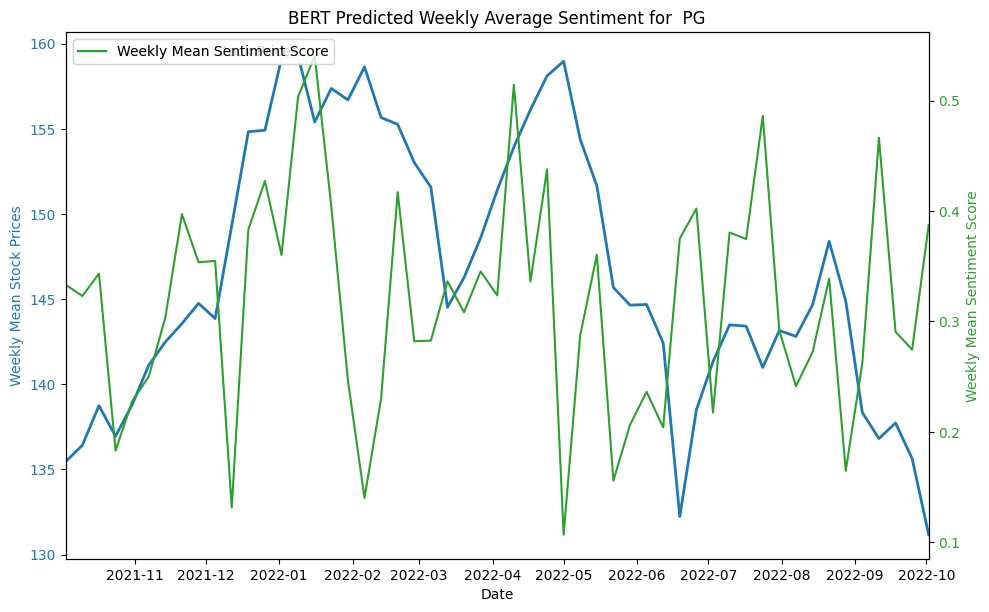

In [ ]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset, SequentialSampler
from datetime import datetime, timedelta

# Use BERT model to predict sentiment scores for each tweet and calculate the mean for each weak and plot alongside with true stock prices for selected stock market

# use cuda to see if gpu is available, else use cpu. analysing with the BERT model is resource intensive...
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# load data
stock_data = pd.read_csv('stock_yfinance_data.csv')
tweets_df = pd.read_csv('stock_tweets.csv')

# load the pre-trained bert-base-uncased model and tokeniser for three labels
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3).to(device)
model.load_state_dict(torch.load('best_bert_model.pth', map_location=device))  # using gpu
model.eval()
tokeniser = BertTokenizer.from_pretrained('bert-base-uncased')

# calculate weekly mean sentiment scores, a seporate funtion from the graphing to be more managable
def predict_sentiment_probs(tweets):
    if isinstance(tweets, str):
        tweets = [tweets]
    elif isinstance(tweets, pd.Series):
        tweets = tweets.tolist()

    # tokenise tweets
    encodings = tokeniser(tweets, truncation=True, padding=True, return_tensors='pt', max_length=128).to(device)

    # make predicted sentiment probabilities
    with torch.no_grad():
        outputs = model(**encodings)
        logits = outputs.logits
        probs = torch.softmax(logits, dim=1)

    # convert probability values to be between -1 and 1
    rescaled_probs = (probs[:, 2] - probs[:, 0]) * 2 - 1

    return rescaled_probs.tolist()

# graphing the weakly mean stock prices and weekly mean sentiment score over time
def plot_stock_and_weekly_sentiment(stock_name):

    # filter for user selected stock name
    stock_data_filtered = stock_data[stock_data['Stock Name'] == stock_name].copy()
    stock_data_filtered['Date'] = pd.to_datetime(stock_data_filtered['Date'], format='%d/%m/%Y')
    stock_data_filtered.set_index('Date', inplace=True)
    desired_stock_tweets = tweets_df[tweets_df['Stock Name'] == stock_name]

    # call BERT model for sentiment analysis with tqdm loading bar
    sentiment_probs = []
    batch_size = 512
    for i in tqdm(range(0, len(desired_stock_tweets), batch_size)):
        batch_tweets = desired_stock_tweets['Tweet'].iloc[i:i+batch_size]
        batch_probs = predict_sentiment_probs(batch_tweets)
        sentiment_probs.extend(batch_probs)

    # add sentiment scores to the tweets dataframe
    desired_stock_tweets['Sentiment_Prob'] = sentiment_probs

    # convert sentiment probabilities into values between -1 and 1
    desired_stock_tweets['Sentiment_Prob'] = (desired_stock_tweets['Sentiment_Prob'] - min(desired_stock_tweets['Sentiment_Prob'])) / (max(desired_stock_tweets['Sentiment_Prob']) - min(desired_stock_tweets['Sentiment_Prob'])) * 2 - 1

    # convert datetime format
    desired_stock_tweets['Date'] = pd.to_datetime(desired_stock_tweets['Date'], format='%Y-%m-%d %H:%M:%S%z')
    desired_stock_tweets.set_index('Date', inplace=True)

    # group tweets and stock data by each week and calculate mean sentiment for each week
    mean_sentiments_per_week = desired_stock_tweets['Sentiment_Prob'].resample('W').mean()
    mean_stock_prices_per_week = stock_data_filtered['Adj Close'].resample('W').mean()

    # graphing
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # blue: stock prices
    color = 'tab:blue'
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Weekly Mean Stock Prices', color=color)
    ax1.plot(mean_stock_prices_per_week.index, mean_stock_prices_per_week.values, color=color, linewidth=2.0, label='Weekly Mean Stock Prices')
    ax1.tick_params(axis='y', labelcolor=color)

    # green: sentiment scores
    ax2 = ax1.twinx()
    color = 'tab:green'
    ax2.set_ylabel('Weekly Mean Sentiment Score', color=color)
    ax2.plot(mean_sentiments_per_week.index, mean_sentiments_per_week.values, color=color, label='Weekly Mean Sentiment Score')
    ax2.legend(loc='upper left')
    ax2.tick_params(axis='y', labelcolor=color)

    # x axis limits for the graph as it was giving gaps
    ax1.set_xlim(mean_stock_prices_per_week.index[0], mean_stock_prices_per_week.index[-1])

    # legend
    ax1.legend(loc='upper left')

    fig.tight_layout()
    plt.title(f'BERT Predicted Weekly Average Sentiment for  {stock_name}')
    plt.show()

def main():
    unique_stock_names = stock_data['Stock Name'].unique()
    print("Ticker Names:", ' '.join(unique_stock_names))
    desired_stock_ticker = input("\nEnter a stock ticker you would like to analyse: ")
    if desired_stock_ticker not in unique_stock_names:
        print("Invalid stock ticker name.")
        return
    plot_stock_and_weekly_sentiment(desired_stock_ticker)

if __name__ == "__main__":
    main()


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Possible Stock Ticker Names: TSLA MSFT PG META AMZN GOOG AMD AAPL NFLX TSM KO F COST DIS VZ CRM INTC BA BX NOC PYPL ENPH NIO ZS XPEV

Enter the name of the stock ticker you'd like to analyze: PG


Processing Tweets: 100%|███████████████████████████████████████| 4089/4089 [00:11<00:00, 346.10it/s]
<ipython-input-2-af1a9589b61f>:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  desired_stock_tweets['SVM Sentiment'] = svm_sentiments
  0%|          | 0/8 [00:00<?, ?it/s]

16/16 [==============================] - 1s 39ms/step


 12%|█▎        | 1/8 [00:01<00:13,  1.89s/it]

16/16 [==============================] - 1s 60ms/step


 25%|██▌       | 2/8 [00:03<00:09,  1.57s/it]

16/16 [==============================] - 1s 69ms/step


 38%|███▊      | 3/8 [00:04<00:07,  1.49s/it]

16/16 [==============================] - 1s 47ms/step


 50%|█████     | 4/8 [00:06<00:05,  1.45s/it]

16/16 [==============================] - 1s 38ms/step


 62%|██████▎   | 5/8 [00:06<00:03,  1.18s/it]

16/16 [==============================] - 1s 39ms/step


 75%|███████▌  | 6/8 [00:08<00:02,  1.24s/it]

16/16 [==============================] - 1s 39ms/step


 88%|████████▊ | 7/8 [00:08<00:01,  1.07s/it]

16/16 [==============================] - 1s 39ms/step


100%|██████████| 8/8 [00:09<00:00,  1.24s/it]
<ipython-input-2-af1a9589b61f>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  desired_stock_tweets['LSTM Sentiment'] = lstm_sentiments
100%|██████████| 8/8 [31:46<00:00, 238.35s/it]
<ipython-input-2-af1a9589b61f>:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  desired_stock_tweets['BERT Sentiment'] = bert_sentiments
<ipython-input-2-af1a9589b61f>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

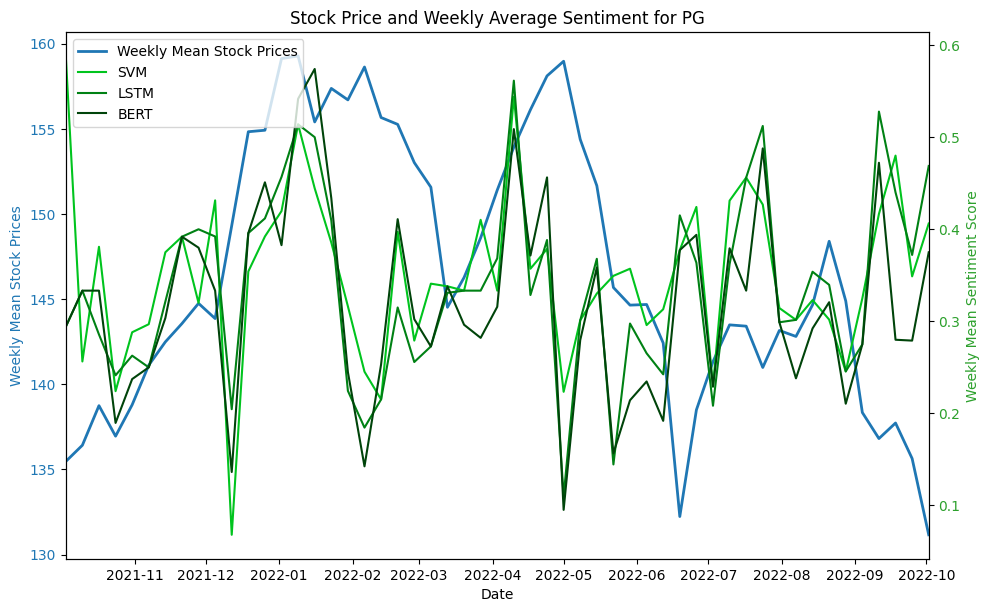

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from joblib import load
from tqdm import tqdm
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset, SequentialSampler
import torch
import numpy as np

# Plot all three of the model's predictions along side eachother to view their differences in predicted sentiment scores better

# use cuda to see if gpu is available, else use cpu. analysing with the BERT model is resource intensive...
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# load data
stock_data = pd.read_csv('stock_yfinance_data.csv')
tweets_df = pd.read_csv('stock_tweets.csv')
svm_model = load('svm_model.joblib')
lstm_model = load_model('best_model.h5')
tokeniser = load('tokeniser.joblib')

# load the pre-trained bert-base-uncased model and tokeniser for three labels
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3).to(device)
model.load_state_dict(torch.load('best_bert_model.pth', map_location=device)) # using gpu
model.eval()
bert_tokeniser = BertTokenizer.from_pretrained('bert-base-uncased')

# SVM analysis
def svm_sentiment_analysis(tweets):
    vectoriser = load('tfidf_vectoriser.joblib')
    sentiments = []
    for tweet in tqdm(tweets, desc="Processing Tweets", ncols=100):
        tweet_vec = vectoriser.transform([tweet])
        sentiment = svm_model.predict(tweet_vec)[0]
        sentiments.append(sentiment)
    return sentiments

# LSTM analysis
def lstm_sentiment_analysis(tweets):
    sequences = tokeniser.texts_to_sequences(tweets)
    max_len = 100
    X_pad = pad_sequences(sequences, maxlen=max_len, padding='post')
    sentiments = lstm_model.predict(X_pad)
    sentiments = np.argmax(sentiments, axis=1) - 1
    return sentiments

# BERT analysis
def predict_sentiment_probs(tweets):
    if isinstance(tweets, str):
        tweets = [tweets]
    elif isinstance(tweets, pd.Series):
        tweets = tweets.tolist()

    # make predicted sentiment probabilities
    encodings = bert_tokenizer(tweets, truncation=True, padding=True, return_tensors='pt', max_length=128).to(device)
    with torch.no_grad():
        outputs = model(**encodings)
        logits = outputs.logits
        probs = torch.softmax(logits, dim=1)

    return probs.tolist()

# all the code here is same as before just all together in one function call

# graphing the weakly mean stock prices and weekly mean sentiment score over time
def plot_stock_and_weekly_sentiment(stock_name):

    # filter for user selected stock name
    stock_data_filtered = stock_data[stock_data['Stock Name'] == stock_name].copy()
    stock_data_filtered['Date'] = pd.to_datetime(stock_data_filtered['Date'], format='%d/%m/%Y')
    stock_data_filtered.set_index('Date', inplace=True)
    desired_stock_tweets = tweets_df[tweets_df['Stock Name'] == stock_name]

    # SVM model sentiment analysis
    svm_sentiments = svm_sentiment_analysis(desired_stock_tweets['Tweet'])
    desired_stock_tweets['SVM Sentiment'] = svm_sentiments

    # LSTM model sentiment analysis
    lstm_sentiments = []
    batch_size = 512
    for i in tqdm(range(0, len(desired_stock_tweets), batch_size)):
        batch_tweets = desired_stock_tweets['Tweet'].iloc[i:i+batch_size]
        batch_sentiments = lstm_sentiment_analysis(batch_tweets)
        lstm_sentiments.extend(batch_sentiments)
    desired_stock_tweets['LSTM Sentiment'] = lstm_sentiments

    # BERT model sentiment analysis
    bert_sentiment_probs = []
    for i in tqdm(range(0, len(desired_stock_tweets), batch_size)):
        batch_tweets = desired_stock_tweets['Tweet'].iloc[i:i+batch_size]
        batch_probs = predict_sentiment_probs(batch_tweets)
        bert_sentiment_probs.extend(batch_probs)
    bert_sentiments = np.argmax(bert_sentiment_probs, axis=1) - 1
    desired_stock_tweets['BERT Sentiment'] = bert_sentiments

    # convert datetime format
    desired_stock_tweets['Date'] = pd.to_datetime(desired_stock_tweets['Date'], format='%Y-%m-%d %H:%M:%S%z')
    desired_stock_tweets.set_index('Date', inplace=True)

    # group tweets and stock data by each week and calculate mean sentiment for each week for each model
    mean_sentiments_per_week_svm = desired_stock_tweets.groupby(pd.Grouper(freq='W'))['SVM Sentiment'].mean()
    mean_sentiments_per_week_lstm = desired_stock_tweets.groupby(pd.Grouper(freq='W'))['LSTM Sentiment'].mean()
    mean_sentiments_per_week_bert = desired_stock_tweets.groupby(pd.Grouper(freq='W'))['BERT Sentiment'].mean()
    mean_stock_prices_per_week = stock_data_filtered['Adj Close'].resample('W').mean()

    # graphing
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # blue: stock prices
    color = 'tab:blue'
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Weekly Mean Stock Prices', color=color)
    ax1.plot(mean_stock_prices_per_week.index, mean_stock_prices_per_week.values, color=color, linewidth=2.0, label='Weekly Mean Stock Prices')
    ax1.tick_params(axis='y', labelcolor=color)

    # green: sentiment scores
    ax2 = ax1.twinx()
    color = 'tab:green'
    ax2.set_ylabel('Weekly Mean Sentiment Score', color=color)
    ax2.plot(mean_sentiments_per_week_svm.index, mean_sentiments_per_week_svm.values, color='#00C41E', label='SVM')
    ax2.plot(mean_sentiments_per_week_lstm.index, mean_sentiments_per_week_lstm.values, color='#008114', label='LSTM')
    ax2.plot(mean_sentiments_per_week_bert.index, mean_sentiments_per_week_bert.values, color='#00440A', label='BERT')
    ax2.tick_params(axis='y', labelcolor=color)

    # x axis limits for the graph as it was giving gaps
    ax1.set_xlim(mean_stock_prices_per_week.index[0], mean_stock_prices_per_week.index[-1])

    # legend
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='upper left')

    fig.tight_layout()
    plt.title(f'Stock Price and Weekly Average Sentiment for {stock_name}')
    plt.show()

def main():
    unique_stock_names = stock_data['Stock Name'].unique()
    print("Ticker Names:", ' '.join(unique_stock_names))
    desired_stock_ticker = input("\nEnter a stock ticker you would like to analyse: ")
    if desired_stock_ticker not in unique_stock_names:
        print("Invalid stock ticker name.")
        return
    plot_stock_and_weekly_sentiment(desired_stock_ticker)

if __name__ == "__main__":
    main()


# Stock price prediction using SVR

Possible Stock Ticker Names: TSLA MSFT PG META AMZN GOOG AMD AAPL NFLX TSM KO F COST DIS VZ CRM INTC BA BX NOC PYPL ENPH NIO ZS XPEV

Enter the name of the stock ticker you'd like to analyze: PG


Processing Tweets: 100%|███████████████████████████████████████| 4089/4089 [00:22<00:00, 184.00it/s]
<ipython-input-4-af74f7f80c10>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  desired_stock_tweets['Sentiment'] = sentiments
<ipython-input-4-af74f7f80c10>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  desired_stock_tweets['Date'] = pd.to_datetime(desired_stock_tweets['Date'], format='%Y-%m-%d %H:%M:%S%z')
<ipython-input-4-af74f7f80c10>:72: FutureWarning: Passing method to DatetimeIndex.get_loc is dep

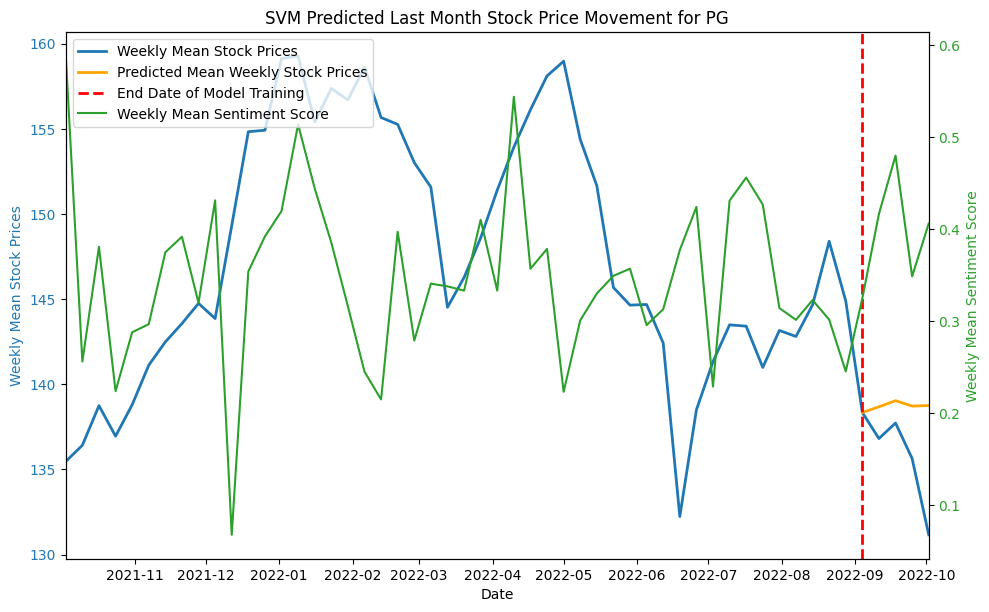

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from joblib import load
from tqdm import tqdm
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
import numpy as np

# train SVR model on the relationship between the weekly mean stock prices and
# weekly mean sentiment scores gathered from the SVM model before the end date
# line to then make weekly mean stock price predictions after the end date line
# based on the sentiment scores during that time

# load data
stock_data = pd.read_csv('stock_yfinance_data.csv')
tweets_df = pd.read_csv('stock_tweets.csv')
svm_model = load('svm_model.joblib')
vectoriser = load('tfidf_vectoriser.joblib')

# graphing the weakly mean stock prices and weekly mean sentiment score over time
def plot_stock_and_weekly_sentiment(stock_name):

    # filter for user selected stock name
    stock_data_filtered = stock_data[stock_data['Stock Name'] == stock_name].copy()
    stock_data_filtered['Date'] = pd.to_datetime(stock_data_filtered['Date'], format='%d/%m/%Y')
    stock_data_filtered.set_index('Date', inplace=True)
    desired_stock_tweets = tweets_df[tweets_df['Stock Name'] == stock_name]

    # call SVM model for sentiment analysis with tqdm loading bar
    sentiments = []
    with tqdm(total=len(desired_stock_tweets), desc="Processing Tweets", ncols=100) as pbar:
        for index, row in desired_stock_tweets.iterrows():
            tweet_vec = vectoriser.transform([row['Tweet']])
            sentiment = svm_model.predict(tweet_vec)[0]
            sentiments.append(sentiment)
            pbar.update(1)
    desired_stock_tweets['Sentiment'] = sentiments

    # convert datetime format
    desired_stock_tweets['Date'] = pd.to_datetime(desired_stock_tweets['Date'], format='%Y-%m-%d %H:%M:%S%z')
    desired_stock_tweets.set_index('Date', inplace=True)

    # group tweets and stock data by each week and calculate mean sentiment for each week
    mean_sentiments_per_week = desired_stock_tweets.groupby(pd.Grouper(freq='W')).agg({'Sentiment': 'mean'})
    mean_stock_prices_per_week = stock_data_filtered['Adj Close'].resample('W').mean()

    # graphing
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # blue: stock prices
    color = 'tab:blue'
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Weekly Mean Stock Prices', color=color)
    ax1.plot(mean_stock_prices_per_week.index, mean_stock_prices_per_week.values, color=color, linewidth=2.0, label='Weekly Mean Stock Prices')
    ax1.tick_params(axis='y', labelcolor=color)

    # green: sentiment scores
    ax2 = ax1.twinx()
    color = 'tab:green'
    ax2.set_ylabel('Weekly Mean Sentiment Score', color=color)
    ax2.plot(mean_sentiments_per_week.index, mean_sentiments_per_week['Sentiment'], color=color, label='Weekly Mean Sentiment Score')
    ax2.tick_params(axis='y', labelcolor=color)

    # train SVR model to predict stock prices after the red end date line
    X = mean_sentiments_per_week.values.reshape(-1, 1)
    y = mean_stock_prices_per_week.values

    # split data into training and testing sets, 20% test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # locate end date
    end_date = mean_stock_prices_per_week.index.max() - pd.DateOffset(months=1)
    intersection_index = mean_stock_prices_per_week.index.get_loc(end_date, method='nearest')

    # train SVR model on data before the red end date line
    X_before_red_line = X[:intersection_index]
    y_before_red_line = y[:intersection_index]
    svr_model_after_red_line = SVR(kernel='rbf')
    svr_model_after_red_line.fit(X_before_red_line, y_before_red_line)

    # make stock price predictions
    predicted_stock_prices_after_red_line = svr_model_after_red_line.predict(X[intersection_index:])

    # aligh predictions to begin at the last stock price value
    intercept_adjustment = mean_stock_prices_per_week.values[intersection_index] - predicted_stock_prices_after_red_line[0]
    predicted_stock_prices_after_red_line += intercept_adjustment

    # plot stock price predictions
    ax1.plot(mean_stock_prices_per_week.index[intersection_index:], predicted_stock_prices_after_red_line, color='orange', linewidth=2.0, label='Predicted Mean Weekly Stock Prices')

    # plot red dashed end date line
    ax1.axvline(x=mean_stock_prices_per_week.index[intersection_index], color='red', linestyle='--', linewidth=2.0, label='End Date of Model Training')

    # x axis limits for the graph as it was giving gaps
    ax1.set_xlim(mean_stock_prices_per_week.index[0], mean_stock_prices_per_week.index[-1])

    # legend
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='upper left')

    fig.tight_layout()
    plt.title(f'SVM Predicted Last Month Stock Price Movement for {stock_name}')
    plt.show()

def main():
    unique_stock_names = stock_data['Stock Name'].unique()
    print("Ticker Names:", ' '.join(unique_stock_names))
    desired_stock_ticker = input("\nEnter a stock ticker you would like to analyse: ")
    if desired_stock_ticker not in unique_stock_names:
        print("Invalid stock ticker name.")
        return
    plot_stock_and_weekly_sentiment(desired_stock_ticker)

if __name__ == "__main__":
    main()


Possible Stock Ticker Names: TSLA MSFT PG META AMZN GOOG AMD AAPL NFLX TSM KO F COST DIS VZ CRM INTC BA BX NOC PYPL ENPH NIO ZS XPEV

Enter the name of the stock ticker you'd like to analyze: PG
128/128 [==============================] - 10s 72ms/step


<ipython-input-8-a56aa95fcd40>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  desired_stock_tweets['Sentiment'] = np.argmax(sentiments, axis=1) - 1
<ipython-input-8-a56aa95fcd40>:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  desired_stock_tweets['Date'] = pd.to_datetime(desired_stock_tweets['Date'], format='%Y-%m-%d %H:%M:%S%z')
<ipython-input-8-a56aa95fcd40>:83: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], meth

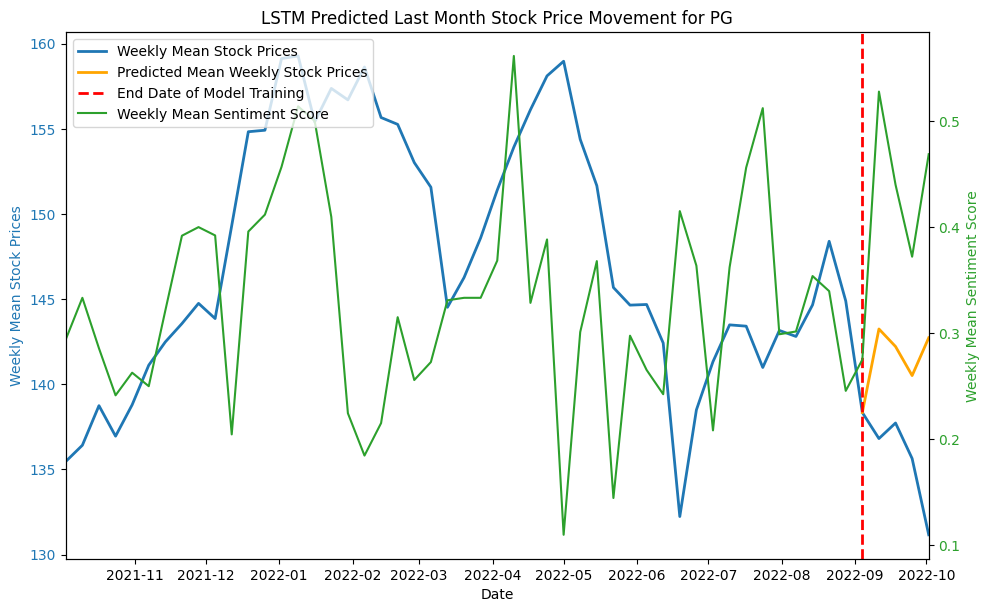

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from joblib import load
from tqdm import tqdm
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
import numpy as np

# train SVR model on the relationship between the weekly mean stock prices and
# weekly mean sentiment scores gathered from the LSTM model before the end date
# line to then make weekly mean stock price predictions after the end date line
# based on the sentiment scores during that time

# load data
stock_data = pd.read_csv('stock_yfinance_data.csv')
tweets_df = pd.read_csv('stock_tweets.csv')
model = load_model('best_model.h5')
tokeniser = load('tokeniser.joblib')

# graphing the weakly mean stock prices and weekly mean sentiment score over time
def plot_stock_and_weekly_sentiment(stock_name):

    # filter for user selected stock name
    stock_data_filtered = stock_data[stock_data['Stock Name'] == stock_name].copy()
    stock_data_filtered['Date'] = pd.to_datetime(stock_data_filtered['Date'], format='%d/%m/%Y')
    stock_data_filtered.set_index('Date', inplace=True)
    desired_stock_tweets = tweets_df[tweets_df['Stock Name'] == stock_name]

    # tokenise text data
    sequences = tokeniser.texts_to_sequences(desired_stock_tweets['Tweet'])
    max_len = 100
    X_pad = pad_sequences(sequences, maxlen=max_len, padding='post')

    # call LSTM model for sentiment analysis (removed tqdm loading bar due to error prints)
    sentiments = model.predict(X_pad)
    sentiments = np.clip(sentiments, -1, 1)

    # add sentiment scores to the tweets dataframe
    desired_stock_tweets['Sentiment'] = np.argmax(sentiments, axis=1) - 1

    # convert datetime format
    desired_stock_tweets['Date'] = pd.to_datetime(desired_stock_tweets['Date'], format='%Y-%m-%d %H:%M:%S%z')
    desired_stock_tweets.set_index('Date', inplace=True)

    # group tweets and stock data by each week and calculate mean sentiment for each week
    mean_sentiments_per_week = desired_stock_tweets.groupby(pd.Grouper(freq='W')).agg({'Sentiment': 'mean'})
    mean_stock_prices_per_week = stock_data_filtered['Adj Close'].resample('W').mean()

    # graphing
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # blue: stock prices
    color = 'tab:blue'
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Weekly Mean Stock Prices', color=color)
    ax1.plot(mean_stock_prices_per_week.index, mean_stock_prices_per_week.values, color=color, linewidth=2.0, label='Weekly Mean Stock Prices')
    ax1.tick_params(axis='y', labelcolor=color)

    # green: sentiment scores
    ax2 = ax1.twinx()
    color = 'tab:green'
    ax2.set_ylabel('Weekly Mean Sentiment Score', color=color)
    ax2.plot(mean_sentiments_per_week.index, mean_sentiments_per_week['Sentiment'], color=color, label='Weekly Mean Sentiment Score')
    ax2.tick_params(axis='y', labelcolor=color)

    # train SVR model to predict stock prices after the red end date line
    X = mean_sentiments_per_week.values.reshape(-1, 1)
    y = mean_stock_prices_per_week.values

    # split data into training and testing sets, 20% test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # locate end date
    end_date = mean_stock_prices_per_week.index.max() - pd.DateOffset(months=1)
    intersection_index = mean_stock_prices_per_week.index.get_loc(end_date, method='nearest')

    # train SVR model on data before the red line
    X_before_red_line = X[:intersection_index]
    y_before_red_line = y[:intersection_index]
    svm_model_after_red_line = SVR(kernel='rbf')
    svm_model_after_red_line.fit(X_before_red_line, y_before_red_line)

    # make stock price predictions
    predicted_stock_prices_after_red_line = svm_model_after_red_line.predict(X[intersection_index:])

    # align predictions to begin at the last stock price value
    intercept_adjustment = mean_stock_prices_per_week.values[intersection_index] - predicted_stock_prices_after_red_line[0]
    predicted_stock_prices_after_red_line += intercept_adjustment

    # plot stock price predictions
    ax1.plot(mean_stock_prices_per_week.index[intersection_index:], predicted_stock_prices_after_red_line, color='orange', linewidth=2.0, label='Predicted Mean Weekly Stock Prices')

    # plot red dashed end date line
    ax1.axvline(x=mean_stock_prices_per_week.index[intersection_index], color='red', linestyle='--', linewidth=2.0, label='End Date of Model Training')

    # x axis limits for the graph as it was giving gaps
    ax1.set_xlim(mean_stock_prices_per_week.index[0], mean_stock_prices_per_week.index[-1])

    # legend
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='upper left')

    fig.tight_layout()
    plt.title(f'LSTM Predicted Last Month Stock Price Movement for {stock_name}')
    plt.show()

def main():
    unique_stock_names = stock_data['Stock Name'].unique()
    print("Ticker Names:", ' '.join(unique_stock_names))
    desired_stock_ticker = input("\nEnter a stock ticker you would like to analyse: ")
    if desired_stock_ticker not in unique_stock_names:
        print("Invalid stock ticker name.")
        return
    plot_stock_and_weekly_sentiment(desired_stock_ticker)

if __name__ == "__main__":
    main()


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Possible Stock Ticker Names: TSLA MSFT PG META AMZN GOOG AMD AAPL NFLX TSM KO F COST DIS VZ CRM INTC BA BX NOC PYPL ENPH NIO ZS XPEV

Enter the name of the stock ticker you'd like to analyze: PG


<ipython-input-2-5d4ba49514bc>:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  desired_stock_tweets['Sentiment'] = sentiment_scores
<ipython-input-2-5d4ba49514bc>:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  desired_stock_tweets['Date'] = pd.to_datetime(desired_stock_tweets['Date'], format='%Y-%m-%d %H:%M:%S%z')
<ipython-input-2-5d4ba49514bc>:99: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.


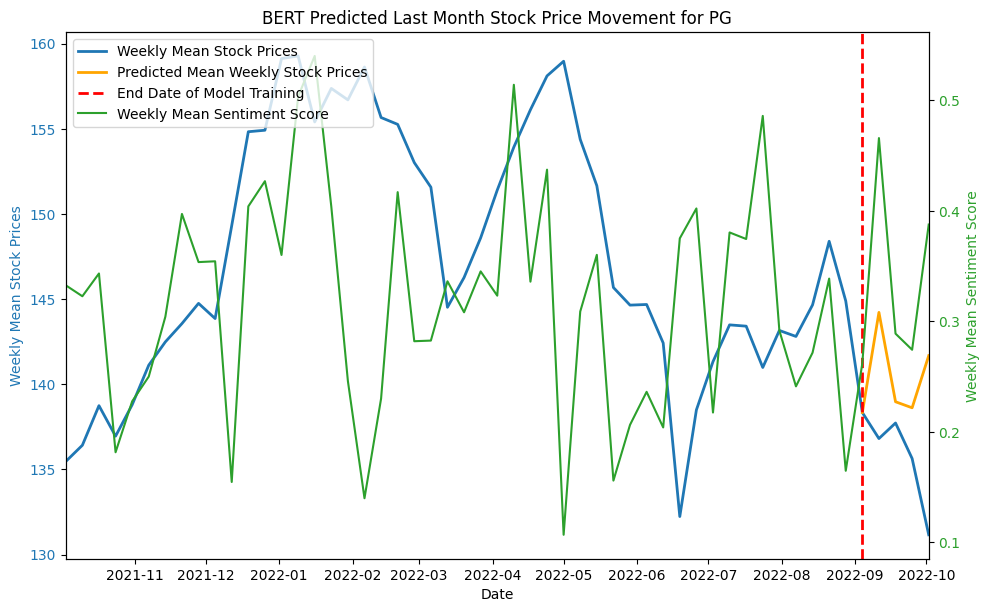

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.svm import SVR
import torch
from tqdm import tqdm
import numpy as np

# train SVR model on the relationship between the weekly mean stock prices and
# weekly mean sentiment scores gathered from the BERT model before the end date
# line to then make weekly mean stock price predictions after the end date line
# based on the sentiment scores during that time

# use cuda to see if gpu is available, else use cpu. analysing with the BERT model is resource intensive...
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# load data
stock_data = pd.read_csv('stock_yfinance_data.csv')
tweets_df = pd.read_csv('stock_tweets.csv')

# load the pre-trained bert-base-uncased model and tokeniser for three labels
tokeniser = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)
model.to(device)
model_path = 'best_bert_model.pth'
state_dict = torch.load(model_path, map_location=torch.device('cpu')) # using cpu
model.load_state_dict(state_dict)
model.eval()

# calculate weekly mean sentiment scores, a seporate funtion from the graphing to be more managable
def calculate_sentiment_scores(text_list):
    sentiment_scores = []
    for text in tqdm(text_list, desc="Calculating sentiment scores", leave=False):
        inputs = tokeniser(text, return_tensors='pt', truncation=True, padding=True)
        inputs.to(device)

        # make predicted sentiment probabilities
        with torch.no_grad():
            outputs = model(**inputs)
            logits = outputs.logits
            probabilities = torch.nn.functional.softmax(logits, dim=1).squeeze(0)
            sentiment_score = probabilities[2].item() - probabilities[0].item()
            sentiment_scores.append(sentiment_score)
    return sentiment_scores


# graphing the weakly mean stock prices and weekly mean sentiment score over time
def plot_stock_and_predict(stock_name):

    # filter for user selected stock name
    stock_data_filtered = stock_data[stock_data['Stock Name'] == stock_name].copy()
    stock_data_filtered['Date'] = pd.to_datetime(stock_data_filtered['Date'], format='%d/%m/%Y')
    stock_data_filtered.set_index('Date', inplace=True)
    desired_stock_tweets = tweets_df[tweets_df['Stock Name'] == stock_name]

    # calculate sentiment scores
    sentiment_scores = calculate_sentiment_scores(desired_stock_tweets['Tweet'].tolist())

    # add sentiment scores to the tweets dataframe
    desired_stock_tweets['Sentiment'] = sentiment_scores

    # convert datetime format
    desired_stock_tweets['Date'] = pd.to_datetime(desired_stock_tweets['Date'], format='%Y-%m-%d %H:%M:%S%z')
    desired_stock_tweets.set_index('Date', inplace=True)

    # group tweets and stock data by each week and calculate mean sentiment for each week
    mean_sentiments_per_week = desired_stock_tweets.groupby(pd.Grouper(freq='W')).agg({'Sentiment': 'mean'})
    mean_stock_prices_per_week = stock_data_filtered['Adj Close'].resample('W').mean()

    # graphing
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # blue: stock prices
    color = 'tab:blue'
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Weekly Mean Stock Prices', color=color)
    ax1.plot(mean_stock_prices_per_week.index, mean_stock_prices_per_week.values, color=color, linewidth=2.0, label='Weekly Mean Stock Prices')
    ax1.tick_params(axis='y', labelcolor=color)

    # green: sentiment scores
    ax2 = ax1.twinx()
    color = 'tab:green'
    ax2.set_ylabel('Weekly Mean Sentiment Score', color=color)
    ax2.plot(mean_sentiments_per_week.index, mean_sentiments_per_week['Sentiment'], color=color, label='Weekly Mean Sentiment Score')
    ax2.tick_params(axis='y', labelcolor=color)

    # locate end date
    end_date = mean_stock_prices_per_week.index.max() - pd.DateOffset(months=1)
    intersection_index = mean_stock_prices_per_week.index.get_loc(end_date, method='nearest')

    # train SVR model to predict stock prices after the red end date line
    X = mean_sentiments_per_week.values.reshape(-1, 1)
    y = mean_stock_prices_per_week.values

    # train SVR model on data before the red end date line
    X_before_red_line = X[:intersection_index]
    y_before_red_line = y[:intersection_index]
    svm_model_after_red_line = SVR(kernel='rbf')
    svm_model_after_red_line.fit(X_before_red_line, y_before_red_line)

    # make stock price predictions
    predicted_stock_prices_after_red_line = svm_model_after_red_line.predict(X[intersection_index:])

    # align predictions to begin at the last stock price value
    intercept_adjustment = mean_stock_prices_per_week.values[intersection_index] - predicted_stock_prices_after_red_line[0]
    predicted_stock_prices_after_red_line += intercept_adjustment

    # plot stock price predictions
    ax1.plot(mean_stock_prices_per_week.index[intersection_index:], predicted_stock_prices_after_red_line, color='orange', linewidth=2.0, label='Predicted Mean Weekly Stock Prices')

    # plot red dashed end date line
    ax1.axvline(x=mean_stock_prices_per_week.index[intersection_index], color='red', linestyle='--', linewidth=2.0, label='End Date of Model Training')

    # x axis limits for the graph as it was giving gaps
    ax1.set_xlim(mean_stock_prices_per_week.index[0], mean_stock_prices_per_week.index[-1])

    # legend
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='upper left')

    fig.tight_layout()
    plt.title(f'BERT Predicted Last Month Stock Price Movement for {stock_name}')
    plt.show()

def main():
    unique_stock_names = stock_data['Stock Name'].unique()
    print("Ticker Names:", ' '.join(unique_stock_names))
    desired_stock_ticker = input("\nEnter a stock ticker you would like to analyse: ")
    if desired_stock_ticker not in unique_stock_names:
        print("Invalid stock ticker name.")
        return
    plot_stock_and_predict(desired_stock_ticker)

if __name__ == "__main__":
    main()


# External Factors Analysis

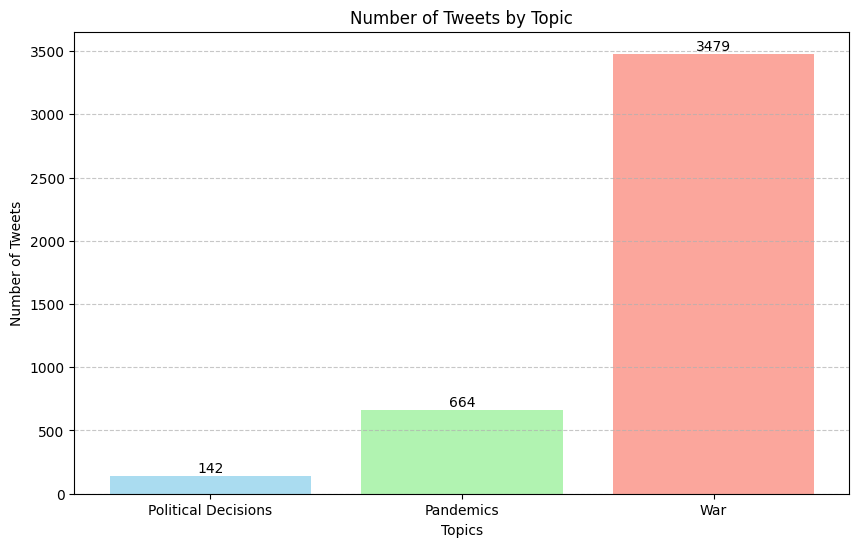

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# filter out all the tweets throughout the analysis dataset that include key
# words in relation to their respective topics and plot the quantity distribution
# for each topic with the raw values above each bar for better clarrity

# load data
df = pd.read_csv("stock_tweets.csv")

# define keywords in relation to the three external topics
political_keywords = ["communist", "communistic", "comminism", "democratic", "democrates", "republic", "republican", "torry", "conservative", "liberal", "presidential election", "presidential elections", "impeachment", "economic sanction", "economic sanctions", "trade agreement", "trade agreements", "tariff", "tariffs", "diplomatic relation", "diplomatic relations", "international summit", "international summits", "peace treaty", "peace treaties", "foreign policy shift", "foreign policy shifts", "government shutdown", "government shutdowns"]
pandemic_keywords = ["covid", "covid-19", "lockdown", "lockdowns", "vaccination", "vaccinations", "variant", "variants", "vaccine passport", "vaccine passports", "herd immunity", "mask mandate", "mask mandates", "booster shot", "booster shots", "quarantine", "quarantines", "pandemic", "pandemics"]
war_keywords = ["ukraine", "taiwan", "isreal", "gaza", "battle", "battles", "war", "wars", "conflict", "conflicts", "ceasefire", "ceasefires", "military intervention", "military interventions", "airstrike", "airstrikes", "troop withdrawal", "troop withdrawals", "civil unrest", "insurgency", "insurgencies", "refugee crisis", "refugee crises", "peace negotiation", "peace negotiations", "humanitarian aid", "humanitarian aids"]

# count tweets containing keywords
def count_tweets_with_keywords(keywords):
    return len(df[df['Tweet'].str.contains('|'.join(keywords), case=False)])

# count tweets for each topic
political_tweets_count = count_tweets_with_keywords(political_keywords)
pandemic_tweets_count = count_tweets_with_keywords(pandemic_keywords)
war_tweets_count = count_tweets_with_keywords(war_keywords)

# graphing
topics = ['Political Decisions', 'Pandemics', 'War']
tweet_counts = [political_tweets_count, pandemic_tweets_count, war_tweets_count]
plt.figure(figsize=(10, 6))
bars = plt.bar(topics, tweet_counts, color=['skyblue', 'lightgreen', 'salmon'], alpha=0.7)
plt.xlabel('Topics')
plt.ylabel('Number of Tweets')
plt.title('Number of Tweets by Topic')

# add value ontop of each bar
for bar, count in zip(bars, tweet_counts):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(count), ha='center', va='bottom')

plt.grid(axis='y', linestyle='--', alpha=0.7) # x axis dashes
plt.show()


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


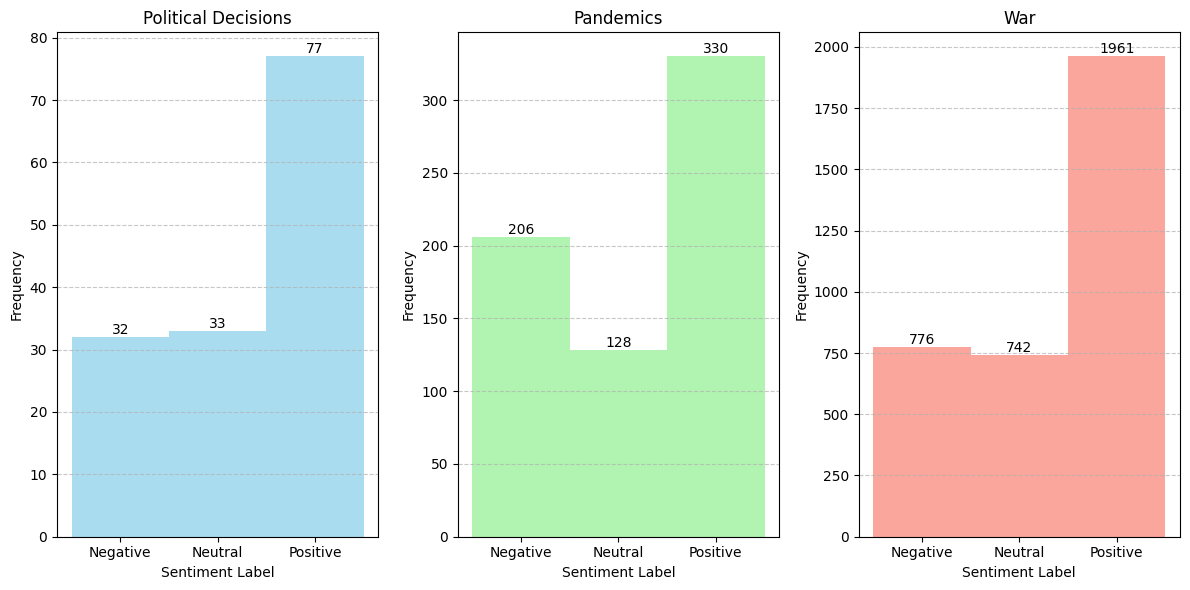

In [ ]:
import pandas as pd
import torch
from transformers import BertTokenizer, BertForSequenceClassification
import matplotlib.pyplot as plt

# use the best peforming BERT model to then predict the sentiment scores of each
# of these filtered tweets and plot the quantity distribution of each tween by
# the three sentiment classes for the three respective topics, again with raw
# quantity values above each bar for better clarity

# load data
df = pd.read_csv("stock_tweets.csv")

# define keywords in relation to the three external topics
political_keywords = ["communist", "communistic", "comminism", "democratic", "democrates", "republic", "republican", "torry", "conservative", "liberal", "presidential election", "presidential elections", "impeachment", "economic sanction", "economic sanctions", "trade agreement", "trade agreements", "tariff", "tariffs", "diplomatic relation", "diplomatic relations", "international summit", "international summits", "peace treaty", "peace treaties", "foreign policy shift", "foreign policy shifts", "government shutdown", "government shutdowns"]
pandemic_keywords = ["covid", "covid-19", "lockdown", "lockdowns", "vaccination", "vaccinations", "variant", "variants", "vaccine passport", "vaccine passports", "herd immunity", "mask mandate", "mask mandates", "booster shot", "booster shots", "quarantine", "quarantines", "pandemic", "pandemics"]
war_keywords = ["ukraine", "taiwan", "isreal", "gaza", "battle", "battles", "war", "wars", "conflict", "conflicts", "ceasefire", "ceasefires", "military intervention", "military interventions", "airstrike", "airstrikes", "troop withdrawal", "troop withdrawals", "civil unrest", "insurgency", "insurgencies", "refugee crisis", "refugee crises", "peace negotiation", "peace negotiations", "humanitarian aid", "humanitarian aids"]

# filter tweets for each topic
political_tweets = df[df['Tweet'].str.contains('|'.join(political_keywords), case=False)]['Tweet'].tolist()
pandemic_tweets = df[df['Tweet'].str.contains('|'.join(pandemic_keywords), case=False)]['Tweet'].tolist()
war_tweets = df[df['Tweet'].str.contains('|'.join(war_keywords), case=False)]['Tweet'].tolist()

# load BERT model and tokeniser (best model)
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)
model.load_state_dict(torch.load('best_bert_model.pth', map_location=torch.device('cpu')))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
model.eval()
tokeniser = BertTokenizer.from_pretrained('bert-base-uncased')

# predict sentiment labels for each tweet
def predict_sentiment(tweet_texts, threshold=0.5):
    sentiment_labels = []
    encoded_inputs = tokeniser(tweet_texts, padding=True, truncation=True, return_tensors='pt')
    input_ids = encoded_inputs['input_ids'].to(device)
    attention_mask = encoded_inputs['attention_mask'].to(device)

    with torch.no_grad():
        for i in range(0, len(input_ids), 128):
            batch_input_ids = input_ids[i:i+128]
            batch_attention_mask = attention_mask[i:i+128]
            outputs = model(batch_input_ids, attention_mask=batch_attention_mask)
            probabilities = torch.softmax(outputs.logits, dim=1)
            predicted_labels = torch.argmax(probabilities, dim=1)
            sentiment_labels.extend(predicted_labels.tolist())

    return sentiment_labels

sentiment_mapping = {0: -1, 1: 0, 2: 1}

# compute sentiment labels for each topic and convert labels
political_sentiments = predict_sentiment(political_tweets)
pandemic_sentiments = predict_sentiment(pandemic_tweets)
war_sentiments = predict_sentiment(war_tweets)

political_sentiments_mapped = [sentiment_mapping[label] for label in political_sentiments]
pandemic_sentiments_mapped = [sentiment_mapping[label] for label in pandemic_sentiments]
war_sentiments_mapped = [sentiment_mapping[label] for label in war_sentiments]

# graphing
plt.figure(figsize=(12, 6))

# political decisions topic:
plt.subplot(1, 3, 1)
counts_political, bins_political, _ = plt.hist(political_sentiments, bins=[-0.5, 0.5, 1.5, 2.5], color='skyblue', alpha=0.7, edgecolor='none')
plt.xlabel('Sentiment Label')
plt.ylabel('Frequency')
plt.title('Political Decisions')
plt.xticks([0, 1, 2], ['Negative', 'Neutral', 'Positive'])
plt.xticks([bin_val for bin_val in range(3)], ['Negative', 'Neutral', 'Positive'])
plt.grid(axis='y', linestyle='--', alpha=0.7)

# display sentiment count values on top of each bar
for i in range(len(counts_political)):
    plt.text(bins_political[i] + 0.5, counts_political[i], str(int(counts_political[i])), ha='center', va='bottom')

# pandemics topic:
plt.subplot(1, 3, 2)
counts_pandemic, bins_pandemic, _ = plt.hist(pandemic_sentiments, bins=[-0.5, 0.5, 1.5, 2.5], color='lightgreen', alpha=0.7, edgecolor='none')
plt.xlabel('Sentiment Label')
plt.ylabel('Frequency')
plt.title('Pandemics')
plt.xticks([0, 1, 2], ['Negative', 'Neutral', 'Positive'])
plt.xticks([bin_val for bin_val in range(3)], ['Negative', 'Neutral', 'Positive'])
plt.grid(axis='y', linestyle='--', alpha=0.7)

# display sentiment count values on top of each bar
for i in range(len(counts_pandemic)):
    plt.text(bins_pandemic[i] + 0.5, counts_pandemic[i], str(int(counts_pandemic[i])), ha='center', va='bottom')

# war topic:
plt.subplot(1, 3, 3)
counts_war, bins_war, _ = plt.hist(war_sentiments, bins=[-0.5, 0.5, 1.5, 2.5], color='salmon', alpha=0.7, edgecolor='none')
plt.xlabel('Sentiment Label')
plt.ylabel('Frequency')
plt.title('War')
plt.xticks([0, 1, 2], ['Negative', 'Neutral', 'Positive'])
plt.xticks([bin_val for bin_val in range(3)], ['Negative', 'Neutral', 'Positive'])
plt.grid(axis='y', linestyle='--', alpha=0.7)

# display sentiment count values on top of each bar
for i in range(len(counts_war)):
    plt.text(bins_war[i] + 0.5, counts_war[i], str(int(counts_war[i])), ha='center', va='bottom')

plt.tight_layout()
plt.show()


# Demo of Bert model


Enter your sentence: this is very bad, that is good


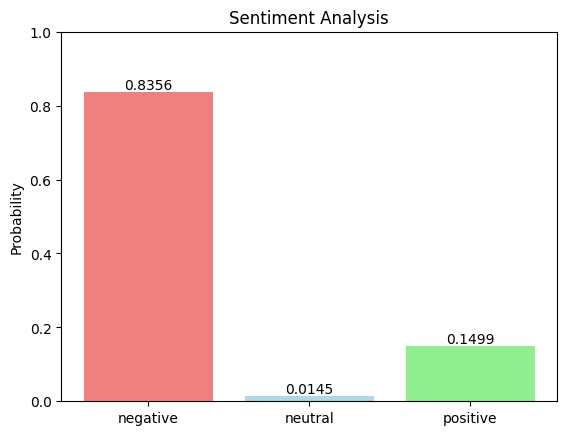

Predicted Sentiment Class: negative


In [ ]:
import matplotlib.pyplot as plt

# a mockup demo for the best performing BERT model to predict the sentiment of
# the input provided by the user and plot the probability distribution of the
# user's input belonging to specific sentiment class - same graph style as before

# create the bar graph of predicted sentiment of inputted sentance from BERT model
def create_sentiment_bar_graph(probabilities):

    colours = {'negative': 'lightcoral', 'neutral': 'lightblue', 'positive': 'lightgreen'}

    # Create bar plot
    fig, ax = plt.subplots()
    bars = ax.bar(range(len(probabilities)), probabilities, color=[colours[sentiment] for sentiment in sentiment_classes])

    # add values to the bars
    for bar, prob in zip(bars, probabilities):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height, f'{prob:.4f}', ha='center', va='bottom')

    # labels and title
    ax.set_xticks(range(len(sentiment_classes)))
    ax.set_xticklabels(sentiment_classes)
    ax.set_ylabel('Probability')
    ax.set_title('Sentiment Analysis')
    ax.set_ylim([0, 1])

    fig.patch.set_alpha(0)
    plt.show()

# user input
input_sentence = input("Enter your sentence: ")
predicted_sentiment, probabilities = predict_sentiment(input_sentence)

sentiment_classes = ['negative', 'neutral', 'positive']
create_sentiment_bar_graph(probabilities)
print("Predicted Sentiment Class:", predicted_sentiment)
